In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
import sys

def get_n_dir_up(path, n):
    for _ in range(n):
        path = os.path.dirname(path)
    return path

CUR_PATH= os.path.abspath("__file__")
sys.path.append(os.path.join(get_n_dir_up(CUR_PATH, 2)))

In [4]:
from utils.eye_plotting import set_general_plt_styles

set_general_plt_styles()

In [5]:
PLOTS_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'results', 'images', 'mvpa2')

In [6]:
import json

DEFAULT_DATA_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'data')
with open(os.path.join(DEFAULT_DATA_FOLDER, 'QA.json')) as f:
    qa_records = json.load(f)

invalid_subjs = qa_records['invalid']

In [7]:
DEFAULT_FEATURE_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 1), 'features')

def load_subject_time_feature(subj, time_steps, normalize=True):
    feature_loaded = []
    subj_result_folder = os.path.join(DEFAULT_FEATURE_FOLDER, f'{int(subj)}')
    subj_combined_feature_path = os.path.join(subj_result_folder, 'combined')
    for tid in time_steps:
        loaded = np.load(os.path.join(subj_combined_feature_path, f'{tid}.npy'))
        feature_loaded.append(loaded)
    features = np.mean(feature_loaded, axis=0) # time average

    if normalize:
        # Z-score normalization
        means = np.mean(features, axis=0)  # Mean of each column
        stds = np.std(features, axis=0)    # Standard deviation of each column
        features = (features - means) / (stds + 1e-5)
        # clap to remove outlier
        clip_range = 5 
        features = np.clip(features, -clip_range, clip_range)
        # convert all to non-negative
        features = (features + clip_range) / (2 * clip_range)

    # also the behavior data
    behavior_data = pd.read_csv(os.path.join(subj_result_folder, 'behavior.csv'))

    return features, behavior_data

In [8]:
all_subjs = os.listdir(DEFAULT_FEATURE_FOLDER)
all_subjs = [subj for subj in all_subjs if subj.isdigit()]
all_subjs = [subj for subj in all_subjs if int(subj) not in invalid_subjs]

In [9]:
PROCESSED_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 
    'results', 'stats', 'gaze', 'inverted_enc')

### Training

In [10]:
from utils.inverted_encoding import deg_signed_diff

In [11]:
from utils.inverted_encoding import ForwardModel

### Get Xs and Ys

### Find best sharpness value

In [12]:
d2_H, d2_W = 15, 15

DEFAULT_FEATURE_CONVERSION = {
    # '0d': { 'old': np.array([0, 1]),},
    '1d': {
        'old': np.arange(2, 32),
        'zoom_ratio': 1.0,
    },
    '2d': {
        'old': np.arange(32, 32+d2_H*d2_W),
        'H': d2_H,
        'W': d2_W,
        'zoom_ratio': 0.4,
    }    
}

In [13]:
sharpness_range = [0.5, 1, 2, 4, 6, 8, 10, 12, 14, 16, 20]

In [14]:
ISI_phase = np.arange(start=2500//50, stop=3000//50).astype(int) # 10 time points
delay_phase = np.arange(start=4750//50, stop=9250//50).astype(int)
delay_phases = np.split(delay_phase, 9) # 9 x 10 time points

#### ISI phase best sharpness

In [15]:
from utils.inverted_encoding import raw_reformat_all_loaded

def reformat_all_loaded(phase, stim_names, cond_lmb):
    return raw_reformat_all_loaded(
        load_func=load_subject_time_feature,
        subjs=all_subjs,
        phase=phase, stim_names=stim_names, 
        cond_lmb=cond_lmb
    )

In [16]:
valid_1st_lmb = lambda df: ((df['stim_1_to_report']) | (df['trial_code'] == 1)).to_numpy()
ISI_xs, ISI_ys, _, _ = reformat_all_loaded(ISI_phase, ['stim_1'], valid_1st_lmb)

In [17]:
DEFAULT_N_CHANNELS = 18 # This does not yeild the minimum reconstrctuion loss but better accuracy?

In [18]:
ISI_forward_model = ForwardModel(
    feature_conversion_params=DEFAULT_FEATURE_CONVERSION, n_channels=DEFAULT_N_CHANNELS)
ISI_best_sharpness, ISI_best_loss = ISI_forward_model.find_best_y_transform(
    ISI_xs, ISI_ys, item_weights=np.ones_like(ISI_ys), 
    sharpness_range=sharpness_range, x_dist_func='euc', x_thresh=1)

sharpness 0.50 loss 0.711573 (invalid: 0.00)
sharpness 1.00 loss 0.711572 (invalid: 0.00)
sharpness 2.00 loss 0.711584 (invalid: 0.00)
sharpness 4.00 loss 0.711594 (invalid: 0.00)
sharpness 6.00 loss 0.711564 (invalid: 0.00)
sharpness 8.00 loss 0.711594 (invalid: 0.00)
sharpness 10.00 loss 0.711720 (invalid: 0.00)
sharpness 12.00 loss 0.711707 (invalid: 0.00)
sharpness 14.00 loss 0.711707 (invalid: 0.00)
sharpness 16.00 loss 0.711706 (invalid: 0.00)
sharpness 20.00 loss 0.711704 (invalid: 0.00)


In [19]:
# ISI_best_sharpness
ISI_best_sharpness

6

#### Delay phase best sharpness

In [20]:
valid_both_lmb = lambda df: (
    (df['stim_1_to_report'] & df['stim_2_to_report']) | 
    (df['trial_code'] == 1)).to_numpy()

delay_xs, delay_ys, delay_dfs, _ = reformat_all_loaded(
    delay_phase, ['stim_1', 'stim_2'], valid_both_lmb)

In [21]:
from utils.inverted_encoding import convert_df_to_delay_design_matrix
item_weights_lmb = lambda df: convert_df_to_delay_design_matrix(df)

In [22]:
delay_forward_model = ForwardModel(
    feature_conversion_params=DEFAULT_FEATURE_CONVERSION, n_channels=DEFAULT_N_CHANNELS)
item_weights = item_weights_lmb(delay_dfs)
delay_best_sharpness, delay_best_loss = delay_forward_model.find_best_y_transform(
    delay_xs, delay_ys, item_weights=item_weights, 
    sharpness_range=sharpness_range, x_dist_func='euc', x_thresh=1)

sharpness 0.50 loss 0.707671 (invalid: 0.00)
sharpness 1.00 loss 0.707674 (invalid: 0.00)
sharpness 2.00 loss 0.707653 (invalid: 0.00)
sharpness 4.00 loss 0.707675 (invalid: 0.00)
sharpness 6.00 loss 0.707685 (invalid: 0.00)
sharpness 8.00 loss 0.707631 (invalid: 0.00)
sharpness 10.00 loss 0.707639 (invalid: 0.00)
sharpness 12.00 loss 0.707653 (invalid: 0.00)
sharpness 14.00 loss 0.707652 (invalid: 0.00)
sharpness 16.00 loss 0.707652 (invalid: 0.00)
sharpness 20.00 loss 0.707652 (invalid: 0.00)


In [23]:
delay_best_sharpness

8

### Convert training data into patterns

In [24]:
DEFAULT_FORWARD_MODEL_PARAMS = {
    'init': {
        'feature_conversion_params': DEFAULT_FEATURE_CONVERSION,
        'n_channels': DEFAULT_N_CHANNELS,
    },
    'forward': {
        'sharpness': delay_best_sharpness,
    }
}

In [25]:
from utils.inverted_encoding import raw_across_subj_cross_phase_iterator

def across_subj_cross_phase_iterator(*args, **kwargs):
    return raw_across_subj_cross_phase_iterator(
        reformat_all_loaded,
        *args, **kwargs
    )

from utils.inverted_encoding import raw_cv_train_test_invert_encoding

def cv_train_test_invert_encoding(*args, **kwargs):
    return raw_cv_train_test_invert_encoding(
        across_subj_cross_phase_iterator,
        *args, **kwargs
    )

## Check decoding quality over the whole delay

In [26]:
n_subjects = len(all_subjs)
full_delay_phase_results = cv_train_test_invert_encoding(
    DEFAULT_FORWARD_MODEL_PARAMS, 
    delay_phase, delay_phase, 
    ['stim_1', 'stim_2'], ['stim_1', 'stim_2'], 
    # valid_both_lmb, valid_both_lmb, 
    None, None,
    item_weights_lmb, n_subjects)

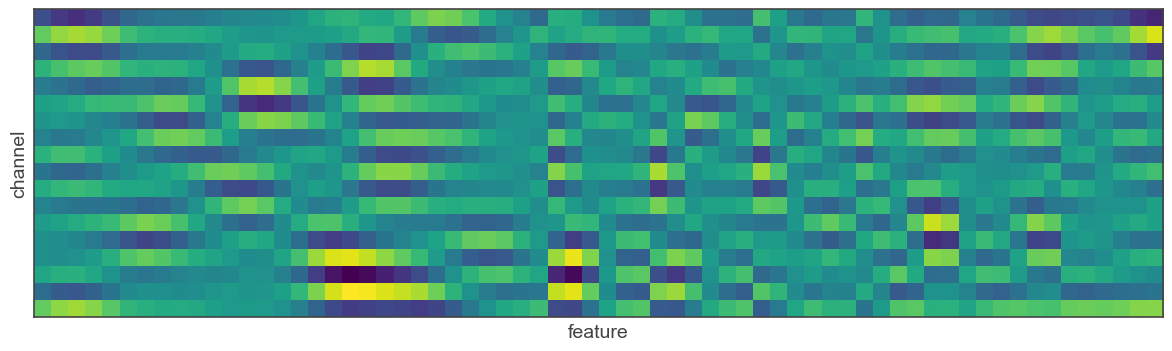

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(25, 4))
ax.imshow(full_delay_phase_results['pattern'])
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('feature', fontsize=14)
ax.set_ylabel('channel', fontsize=14)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_phase_channel_pattern.png')
plt.savefig(plot_path, bbox_inches='tight')

In [28]:
delay_model = ForwardModel(**DEFAULT_FORWARD_MODEL_PARAMS['init'])
delay_sharpness = DEFAULT_FORWARD_MODEL_PARAMS['forward']['sharpness']

channel_weight_projection = delay_model.raw_ys_to_channel_weights(
    np.arange(180), delay_sharpness)
full_patterns = channel_weight_projection @ full_delay_phase_results['pattern'] 
pattern_mask = np.arange(9) * 20 + 10

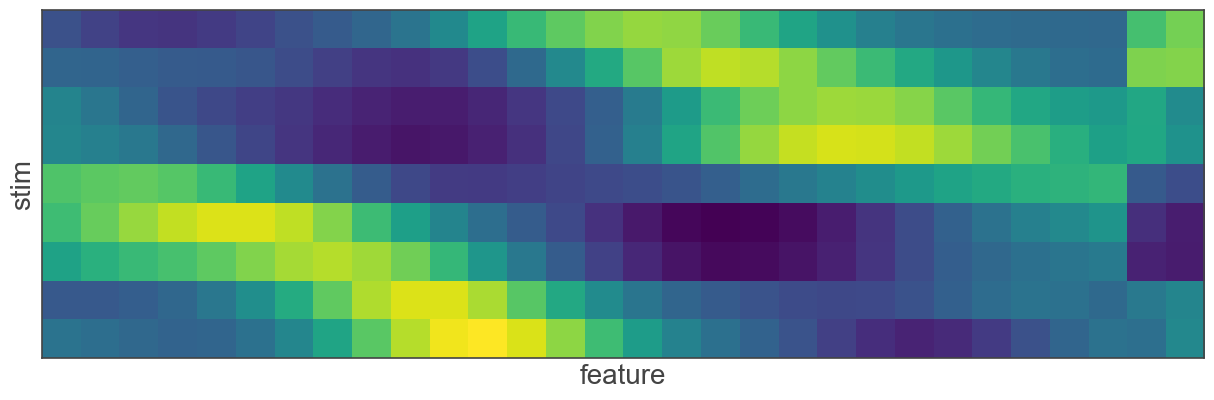

In [29]:
# display 1d patterns
fig, ax = plt.subplots(1, figsize=(15, 10))
selected_pattern = full_patterns[pattern_mask]
f_mask = DEFAULT_FEATURE_CONVERSION['1d']['old']
selected_pattern = selected_pattern[:, f_mask]
ax.imshow(selected_pattern, origin='lower')
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('stim', fontsize=20)
ax.set_xlabel('feature', fontsize=20)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_phase_pattern_1d.png')
plt.savefig(plot_path, bbox_inches='tight')

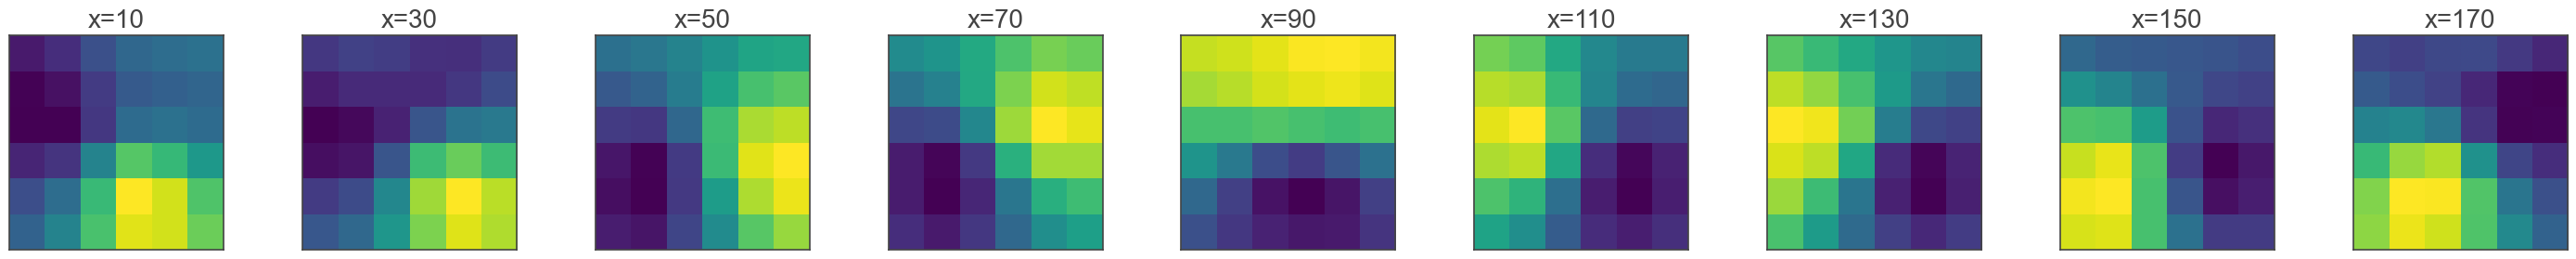

In [30]:
# display 2d patterns
fig, axs = plt.subplots(1, len(pattern_mask), figsize=(4*len(pattern_mask), 3))
selected_pattern = full_patterns[pattern_mask]
f_mask_start = int(len(DEFAULT_FEATURE_CONVERSION['1d']['old']) * DEFAULT_FEATURE_CONVERSION['1d']['zoom_ratio'])
f_mask_start = (f_mask_start + 2) if '0d' in DEFAULT_FEATURE_CONVERSION else f_mask_start
selected_pattern = selected_pattern[:, f_mask_start:]

for i in range(len(pattern_mask)):
    ax = axs[i]
    cond_pattern = selected_pattern[i]
    pattern_H = int(
        DEFAULT_FEATURE_CONVERSION['2d']['H'] * DEFAULT_FEATURE_CONVERSION['2d']['zoom_ratio'])
    pattern_W = int(
        DEFAULT_FEATURE_CONVERSION['2d']['W'] * DEFAULT_FEATURE_CONVERSION['2d']['zoom_ratio'])
    cond_pattern = cond_pattern.reshape(pattern_H, pattern_W)
    ax.imshow(cond_pattern, origin='lower')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'x={pattern_mask[i]}', fontsize=20)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_phase_pattern_2d.png')
plt.savefig(plot_path, bbox_inches='tight')

### center all encoded

#### convert channel weights to (distribution of) stimuli

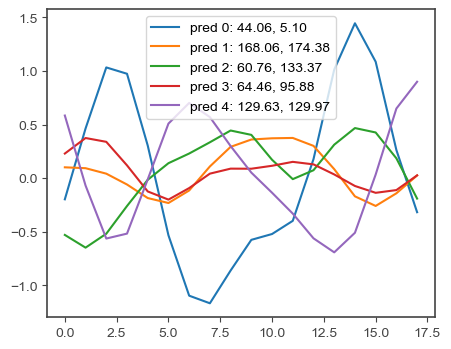

In [31]:
fig, ax = plt.subplots(1, figsize=(5, 4))
for i in range(5):
    y = full_delay_phase_results['test_ys'][i]
    l = full_delay_phase_results['preds'][i]
    ax.plot(l, label=f'pred {i}: {y[0]:.2f}, {y[1]:.2f}')
ax.legend()

In [32]:
DELAY_CHANNEL_PRED_MEAN = np.mean(full_delay_phase_results['preds'])
DELAY_CHANNEL_PRED_STD = np.std(full_delay_phase_results['preds'])
print(f'Delay channel prediction mean: {DELAY_CHANNEL_PRED_MEAN:.2f} std: {DELAY_CHANNEL_PRED_STD:.2f}')

Delay channel prediction mean: 0.06 std: 0.42


In [33]:
from utils.inverted_encoding import raw_channel_weights_to_pseudo_distrib

def channel_weights_to_pseudo_distrib(channel_weights, model, sharpness):
    return raw_channel_weights_to_pseudo_distrib(
       channel_weights, model, sharpness,
       delay_channel_pred_mean=DELAY_CHANNEL_PRED_MEAN,
       delay_channel_pred_std=DELAY_CHANNEL_PRED_STD
    )
    

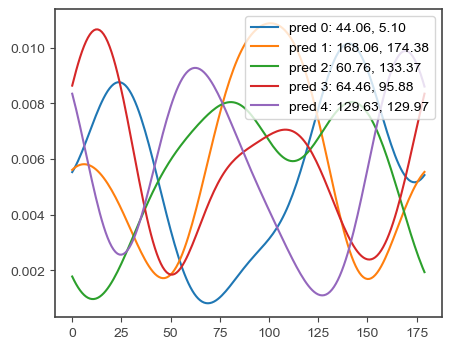

In [34]:
example_converted = channel_weights_to_pseudo_distrib(
    full_delay_phase_results['preds'], delay_model, 
    sharpness=30)
fig, ax = plt.subplots(1, figsize=(5, 4))
for i in range(5):
    y = full_delay_phase_results['test_ys'][i]
    l = example_converted[i]
    ax.plot(l, label=f'pred {i}: {y[0]:.2f}, {y[1]:.2f}')
ax.legend()

#### flip and adjust the distribution --> so it aligns with the target we are checking

In [35]:
from utils.inverted_encoding import shift_align_distrib

In [36]:
from utils.inverted_encoding import raw_display_shifted_distrib

def display_shifted_distrib(*args, **kwargs):
    if 'ylim_min' not in kwargs:
        kwargs['ylim_min'] = 0.0040
    if 'ylim_max' not in kwargs:
        kwargs['ylim_max'] = 0.0075
    return raw_display_shifted_distrib(*args, **kwargs)

#### Combine visualization

In [37]:
has_valid_prev_lmb = lambda df: ~(df['prev_last_response'].isna().values)
has_valid_prev_mask = has_valid_prev_lmb(full_delay_phase_results['test_df'])

In [38]:
from utils.inverted_encoding import raw_display_stats_and_distrib

def display_stats_and_distrib(
        ax, # set to None to disable visualization
        results, stats_type, 
        common_lmb=None, condition_lmbs={}, item_weights_lmb=None, 
        sharpness=delay_best_sharpness, # sharpness to convert to distrib
        return_subj_stats=False, # if to return each subject's stats
        zoom_out=True, # change the size of label for different plots
    ):
    return raw_display_stats_and_distrib(
        ax, results, stats_type, 
        common_lmb=common_lmb, condition_lmbs=condition_lmbs, 
        item_weights_lmb=item_weights_lmb,
        sharpness=sharpness, return_subj_stats=return_subj_stats,
        surrogate_model=delay_model,
        prediction_conversion_func=channel_weights_to_pseudo_distrib,
        display_shifted_distrib_func=display_shifted_distrib,
        zoom_out=zoom_out
    )


In [39]:
from utils.inverted_encoding import print_stats_results_as_tables

In [40]:
DEF_PLOT_W, DEF_PLOT_H = 6, 6

### Firstly, check the combined

In [41]:
stim1_valid_lmb = lambda df: ((df['trial_code'] == 1) | (df['stim_1_to_report'])).to_numpy()
stim2_valid_lmb = lambda df: ((df['trial_code'] == 1) | (df['stim_2_to_report'])).to_numpy()

--- accuracy ---
           mean    sem  t_stat  p_val  df
stim 1    0.697  0.083  8.3532    0.0  35
stim 2    0.504  0.081  6.1901    0.0  35
combined  0.608  0.072  8.4988    0.0  35
--- bias ---
           mean  sem (1e-3)  t_stat   p_val  df
stim 1   -0.008       0.091 -0.0911  0.5360  35
stim 2    0.062       0.061  1.0257  0.1560  35
combined  0.034       0.060  0.5665  0.2873  35


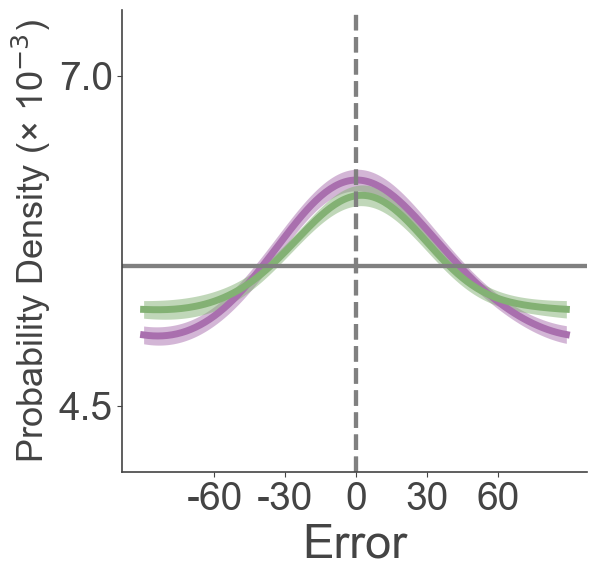

In [43]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
        'to_plot': False,
    },
}
stats_results = display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='accuracy', 
    common_lmb=None, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
# print(stats_results)
print_stats_results_as_tables(stats_results)
# ax.set_title('Errors: full delay phase', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')


In [44]:
both_has_prev_lmb = lambda df: (has_valid_prev_lmb(df) & valid_both_lmb(df))

ValueError: `x` and `y` must have the same length along `axis`.

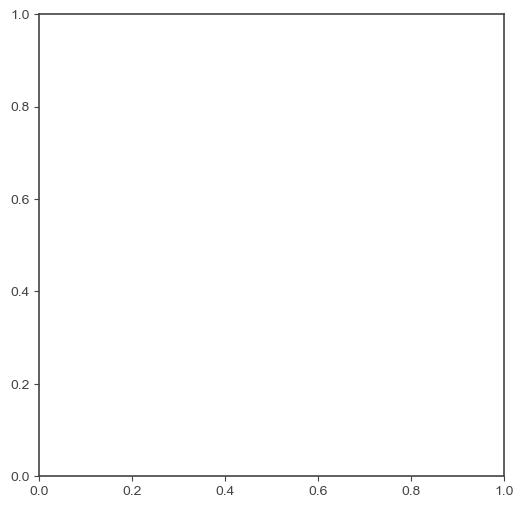

In [45]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}
stats_results = display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='sd', 
    common_lmb=has_valid_prev_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
print_stats_results_as_tables(stats_results)
# ax.set_title('SD: full delay phase', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_sd.png')
plt.savefig(plot_path, bbox_inches='tight')


--- bias ---
           mean  sem (1e-3)  t_stat   p_val
stim 1    0.145       0.081  1.7992  0.0806
stim 2    0.284       0.081  3.5259  0.0012
combined  0.191       0.062  3.0923  0.0039


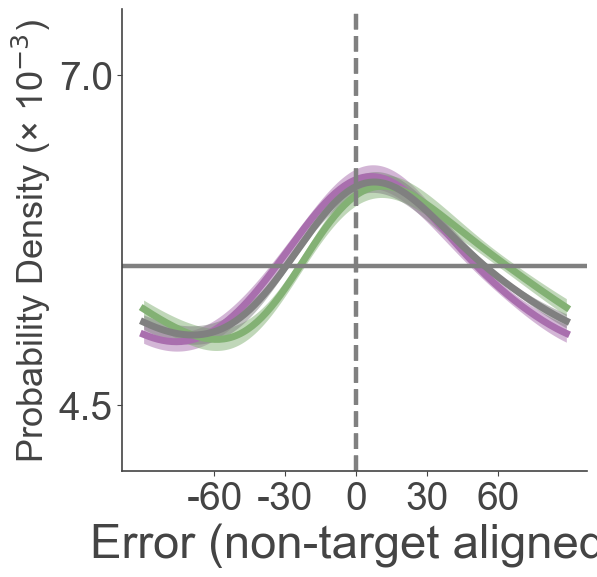

In [ ]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}
stats_results = display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='sur', 
    common_lmb=None, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
print_stats_results_as_tables(stats_results)
# ax.set_title('SUR: full delay phase', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_sur.png')
plt.savefig(plot_path, bbox_inches='tight')

#### certain v.s. uncertain?

--- accuracy ---
           mean    sem  t_stat  p_val  df
stim 1    0.704  0.099  7.1401    0.0  35
stim 2    0.451  0.084  5.3385    0.0  35
combined  0.591  0.076  7.7601    0.0  35
--- bias ---
           mean  sem (1e-3)  t_stat   p_val  df
stim 1   -0.033       0.113 -0.2964  0.6157  35
stim 2    0.085       0.072  1.1806  0.1229  35
combined  0.035       0.071  0.4999  0.3101  35


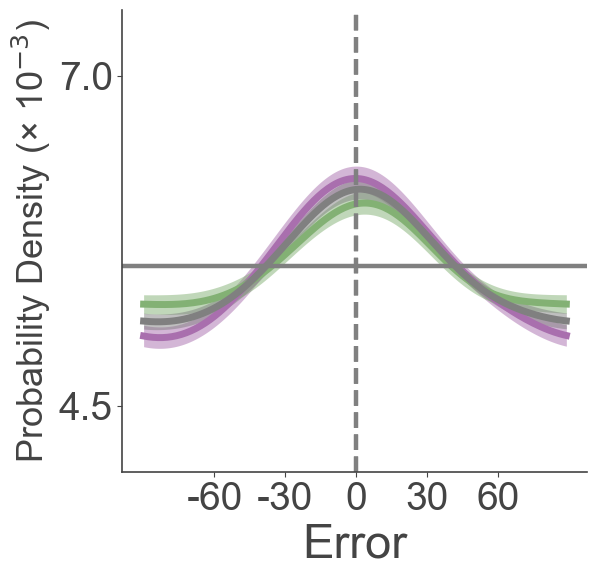

In [46]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))

certain_both_lmb = lambda df: ((df['trial_code'] == 0) | (df['stim_1_to_report'] & df['stim_2_to_report'])).values
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}
stats_results = display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='accuracy', 
    common_lmb=certain_both_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)

print_stats_results_as_tables(stats_results)


--- accuracy ---
           mean    sem  t_stat  p_val  df
stim 1    0.712  0.091  7.8683    0.0  35
stim 2    0.460  0.087  5.2955    0.0  35
combined  0.587  0.078  7.5304    0.0  35
--- bias ---
           mean  sem (1e-3)  t_stat   p_val  df
stim 1   -0.022       0.099 -0.2237  0.5878  35
stim 2    0.060       0.066  0.8999  0.1872  35
combined  0.019       0.067  0.2826  0.3896  35


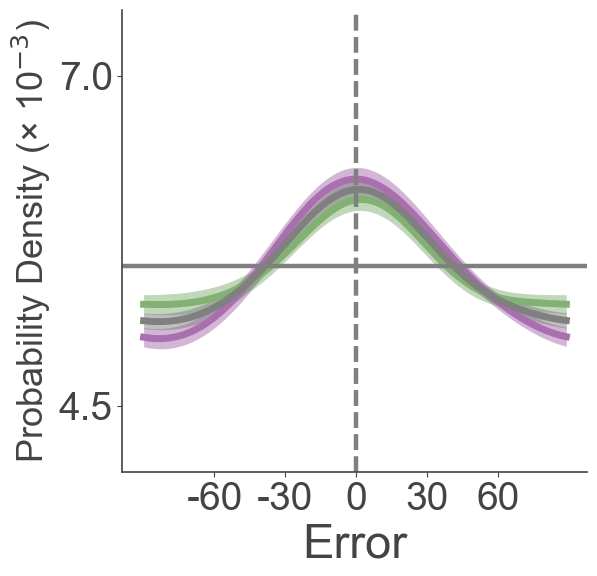

In [47]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))

uncertain_both_lmb = lambda df: ((df['trial_code'] == 1) | (df['stim_1_to_report'] & df['stim_2_to_report'])).values
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}
stats_results = display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='accuracy', 
    common_lmb=uncertain_both_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)

print_stats_results_as_tables(stats_results)


**comment**: ok certainty does not matter

#### for comparison: check one item only decoding-encoding

In [48]:
stim1_only_lmb = lambda df: ((df['trial_code'] == 0) & (~(df['stim_2_to_report']))).to_numpy()
stim2_only_lmb = lambda df: ((df['trial_code'] == 0) & (~(df['stim_1_to_report']))).to_numpy()
valid_single_item_lmb = lambda df: (stim1_only_lmb(df) | stim2_only_lmb(df))

--- accuracy ---
           mean    sem  t_stat  p_val  df
stim 1    0.605  0.111  5.4512    0.0  35
stim 2    0.737  0.106  6.9440    0.0  35
combined  0.681  0.089  7.6166    0.0  35
--- bias ---
           mean  sem (1e-3)  t_stat   p_val  df
stim 1    0.069       0.105  0.6575  0.2576  35
stim 2    0.060       0.112  0.5342  0.2983  35
combined  0.081       0.074  1.0890  0.1418  35


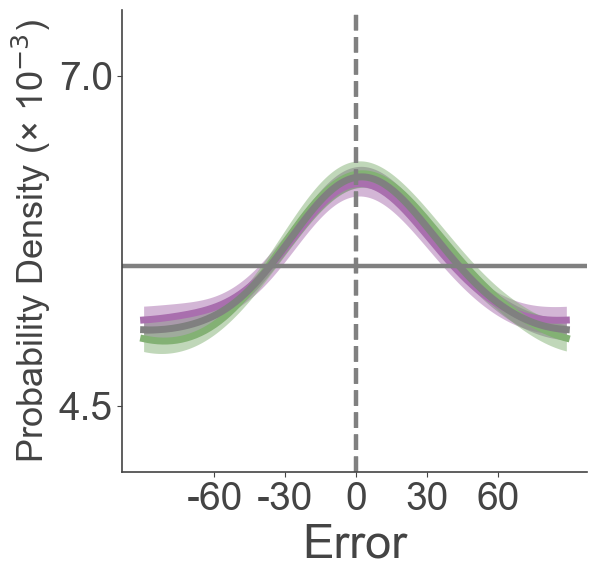

In [49]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_only_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_only_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}
stats_results = display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='accuracy', 
    common_lmb=valid_single_item_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
print_stats_results_as_tables(stats_results)
# ax.set_title('Errors: full delay phase (1 item)', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, '1item_delay_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

In [50]:
single_has_prev_lmb = lambda df: (has_valid_prev_lmb(df) & valid_single_item_lmb(df))

--- bias ---
           mean  sem (1e-3)  t_stat   p_val  df
stim 1   -0.059       0.109 -0.5415  0.7042  35
stim 2    0.121       0.085  1.4239  0.0817  35
combined -0.008       0.058 -0.1356  0.5536  35


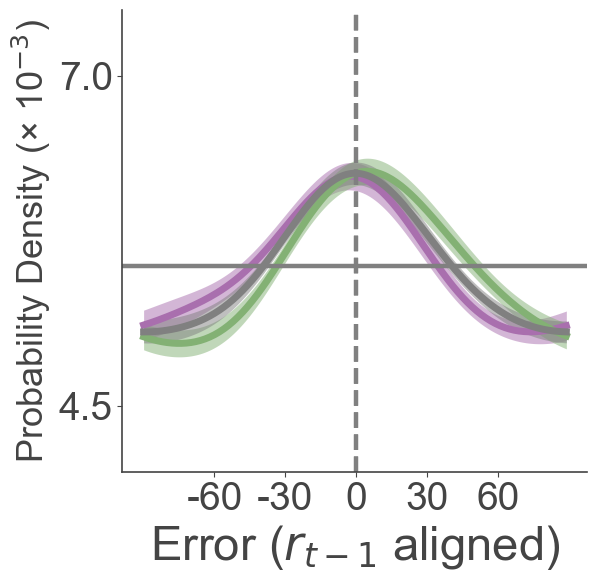

In [51]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_only_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_only_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}
stats_results = display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='sd', 
    common_lmb=single_has_prev_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
print_stats_results_as_tables(stats_results)
# ax.set_title('SD: full delay phase (1 item)', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, '1item_delay_decoded_sd.png')
plt.savefig(plot_path, bbox_inches='tight')

--- bias ---
           mean  sem (1e-3)  t_stat   p_val  df
stim 1   -0.028       0.082 -0.3451  0.6340  35
stim 2   -0.057       0.095 -0.6047  0.7254  35
combined -0.020       0.063 -0.3181  0.6239  35


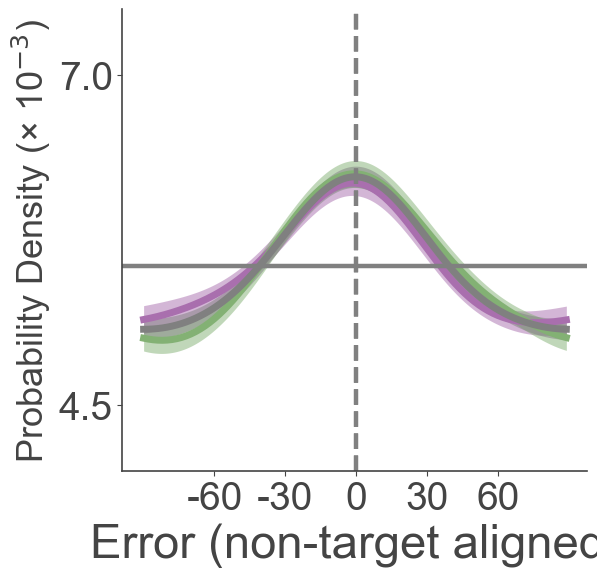

In [52]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_only_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_only_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}
stats_results = display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='sur', 
    common_lmb=valid_single_item_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
print_stats_results_as_tables(stats_results)
# ax.set_title('SUR: full delay phase (1 item)', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, '1item_delay_decoded_sur.png')
plt.savefig(plot_path, bbox_inches='tight')

#### group by serial difference

In [53]:
serial_diffs_s1_lmb = lambda df: np.abs(deg_signed_diff(
    df['prev_last_response'].values - df['stim_1'].values))
serial_diffs_s2_lmb = lambda df: np.abs(deg_signed_diff(
    df['prev_last_response'].values - df['stim_2'].values)) 

--- accuracy ---
         mean    sem  t_stat   p_val  df
stim 1  0.876  0.140  6.2361  0.0000  35
stim 2  0.426  0.137  3.1193  0.0018  35
--- bias ---
         mean  sem (1e-3)  t_stat   p_val  df
stim 1  0.109       0.148  0.7378  0.2328  35
stim 2 -0.060       0.148 -0.4043  0.6558  35


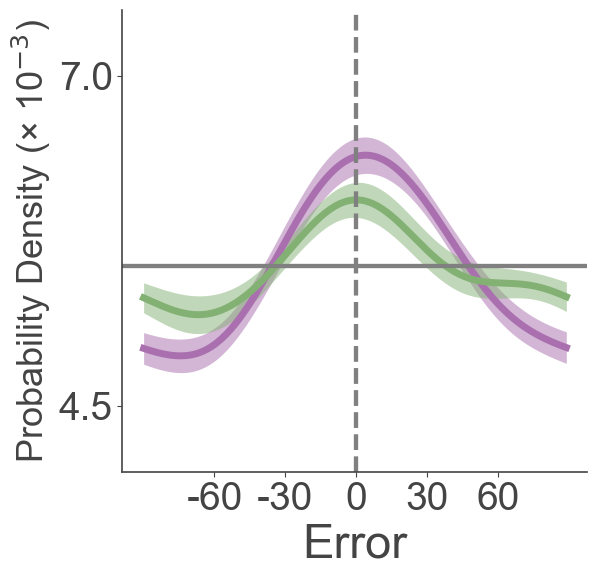

In [54]:
small_sd1_lmb = lambda d: (serial_diffs_s1_lmb(d) < 30)
small_sd2_lmb = lambda d: (serial_diffs_s2_lmb(d) < 30)

fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': small_sd1_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': small_sd2_lmb,
    },
}
stats_results = display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='accuracy', 
    common_lmb=both_has_prev_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
print_stats_results_as_tables(stats_results)
# ax.set_title('full delay phase error: small SD diff', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_small_sd_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

--- bias ---
         mean  sem (1e-3)  t_stat   p_val  df
stim 1  0.074       0.145  0.5139  0.3053  35
stim 2  0.339       0.123  2.7570  0.0046  35


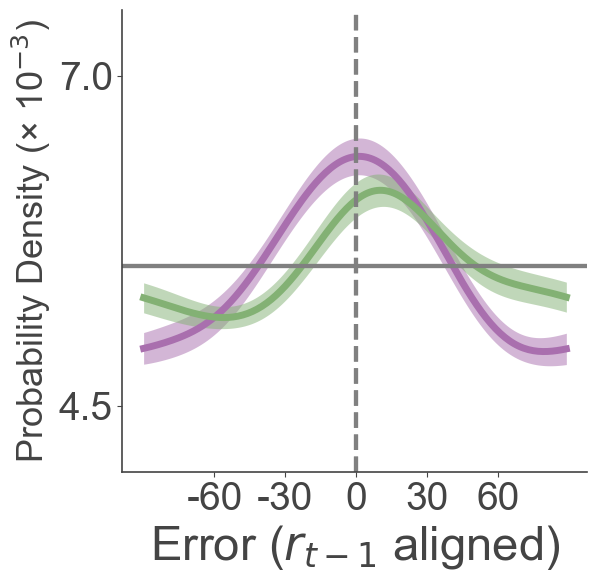

In [55]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': small_sd1_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': small_sd2_lmb,
    },
}
stats_results = display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='sd', 
    common_lmb=both_has_prev_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
print_stats_results_as_tables(stats_results)
# ax.set_title('full delay phase sd bias: small SD diff', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_small_sd_sd.png')
plt.savefig(plot_path, bbox_inches='tight')

--- accuracy ---
         mean    sem  t_stat  p_val  df
stim 1  0.788  0.129  6.0971    0.0  35
stim 2  0.659  0.105  6.2503    0.0  35
--- bias ---
         mean  sem (1e-3)  t_stat   p_val  df
stim 1 -0.131       0.156 -0.8397  0.7966  35
stim 2  0.071       0.107  0.6639  0.2555  35


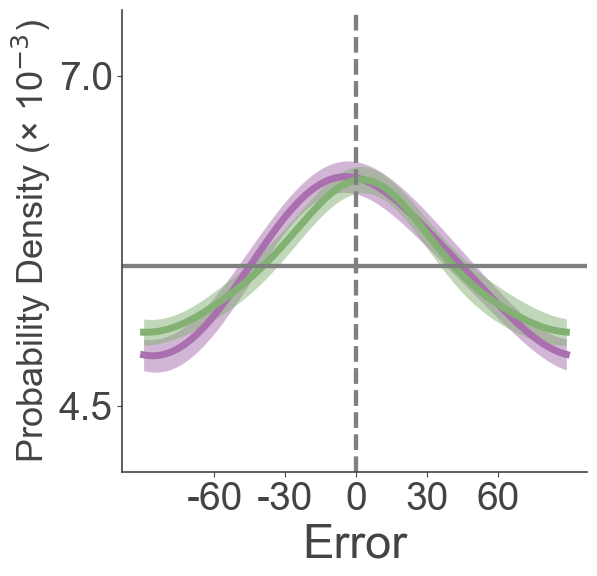

In [56]:
mid_sd1_lmb = lambda d: ((serial_diffs_s1_lmb(d) >= 30) & (serial_diffs_s1_lmb(d) < 60))
mid_sd2_lmb = lambda d: ((serial_diffs_s2_lmb(d) >= 30) & (serial_diffs_s2_lmb(d) < 60))

fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': mid_sd1_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': mid_sd2_lmb,
    },
}
stats_results = display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='accuracy', 
    common_lmb=both_has_prev_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
print_stats_results_as_tables(stats_results)
# ax.set_title('full delay phase error: medium SD diff', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_mid_sd_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

--- bias ---
         mean  sem (1e-3)  t_stat   p_val  df
stim 1 -0.118       0.129 -0.9186  0.8177  35
stim 2 -0.129       0.132 -0.9726  0.8313  35


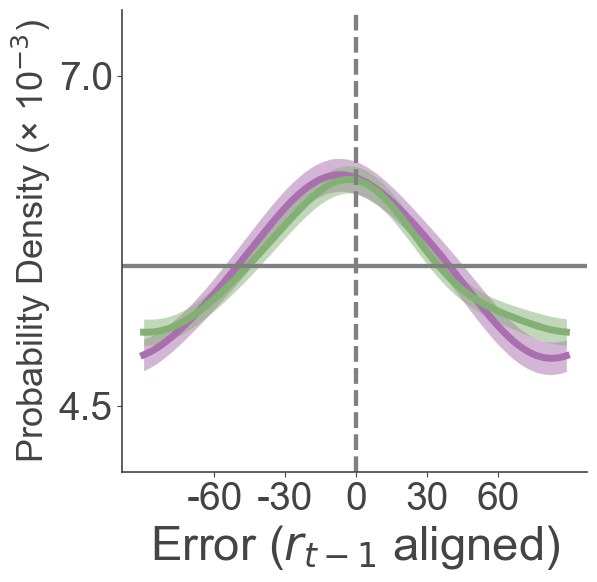

In [57]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': mid_sd1_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': mid_sd2_lmb,
    },
}
stats_results = display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='sd', 
    common_lmb=both_has_prev_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
print_stats_results_as_tables(stats_results)
# ax.set_title('full delay phase sd bias: medium SD diff', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_mid_sd_sd.png')
plt.savefig(plot_path, bbox_inches='tight')

--- accuracy ---
         mean    sem  t_stat   p_val  df
stim 1  0.547  0.133  4.1191  0.0001  35
stim 2  0.280  0.140  2.0085  0.0262  35
--- bias ---
         mean  sem (1e-3)  t_stat   p_val  df
stim 1 -0.102       0.113 -0.9068  0.8147  35
stim 2  0.041       0.128  0.3236  0.3741  35


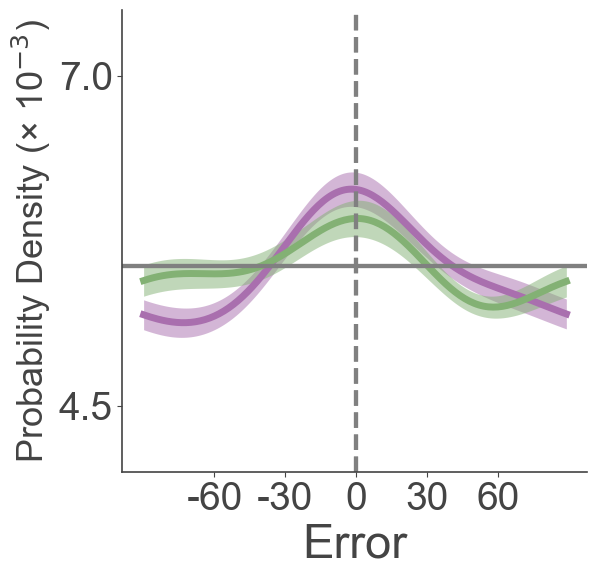

In [58]:
large_sd1_lmb = lambda d: (serial_diffs_s1_lmb(d) >= 60)
large_sd2_lmb = lambda d: (serial_diffs_s2_lmb(d) >= 60)

fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': large_sd1_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': large_sd2_lmb,
    },
}
stats_results = display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='accuracy', 
    common_lmb=both_has_prev_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
print_stats_results_as_tables(stats_results)
# ax.set_title('full delay phase error: large SD diff', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_large_sd_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

--- bias ---
        mean  sem (1e-3)  w_stat   p_val     n  t_stat    df
stim 1 -0.26       0.140   185.0  0.9908  36.0     NaN   NaN
stim 2 -0.18       0.139     NaN  0.8992   NaN -1.3014  35.0


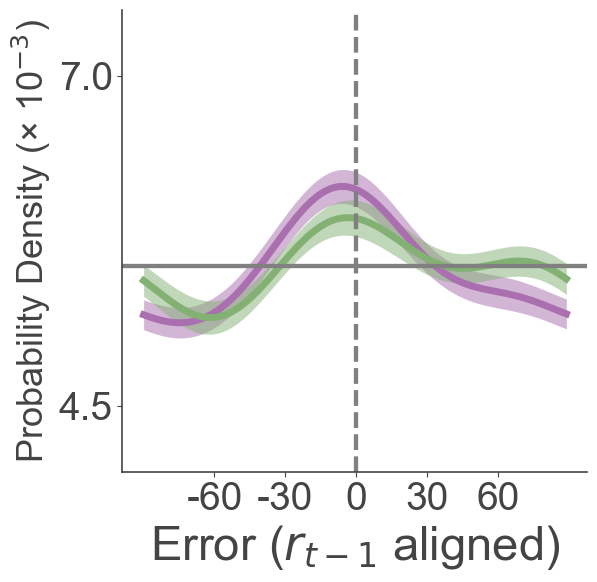

In [60]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': large_sd1_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': large_sd2_lmb,
    },
}
stats_results = display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='sd', 
    common_lmb=both_has_prev_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
print_stats_results_as_tables(stats_results)
# ax.set_title('full delay phase sd bias: large SD diff', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_large_sd_sd.png')
plt.savefig(plot_path, bbox_inches='tight')

#### Compare different modes?

In [61]:
MODE_COLOR_MAPPINGS = {
    'draw': 'skyblue',
    'click': 'coral',
}

In [62]:
from utils.stats_test import display_ttest_rel2_results

accuracy: t(35)=-2.22 (p=0.033)
bias: t(35)=0.10 (p=0.921)


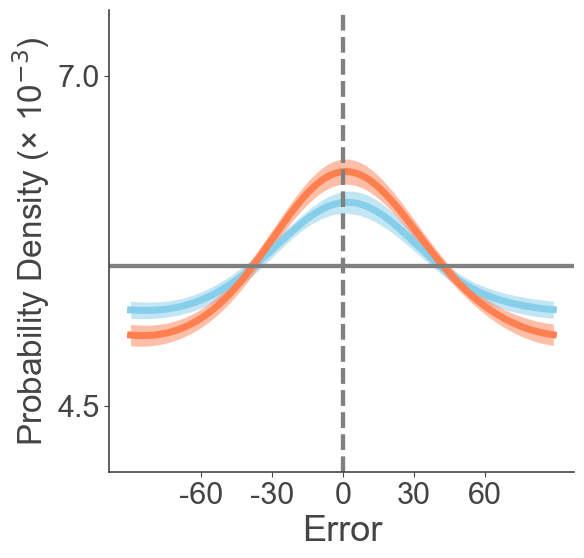

In [66]:
draw_lmb = lambda df: (df['mode'] == 'draw').to_numpy()
click_lmb = lambda df: (df['mode'] == 'click').to_numpy()

fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'draw': {
        'target': 'combined',
        'lmb': draw_lmb,
        'plot_settings': {
            'plot_line_color': MODE_COLOR_MAPPINGS['draw'],
            'plot_line_style': '-',
            'plot_line_alpha': 1,
        },
    },
    'wheel': {
        'target': 'combined',
        'lmb': click_lmb,
        'plot_settings': {
            'plot_line_color': MODE_COLOR_MAPPINGS['click'],
            'plot_line_style': '-',
            'plot_line_alpha': 1,
        },
    },
}

_, stats_results = display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='accuracy', 
    common_lmb=None, 
    condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb,
    return_subj_stats=True,
    zoom_out=False
)

# stats results: subject stats -- 2 
display_ttest_rel2_results(stats_results, ['draw', 'wheel'])
# ax.set_title('full delay phase error: draw&click', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_modes_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

bias: t(35)=0.24 (p=0.813)


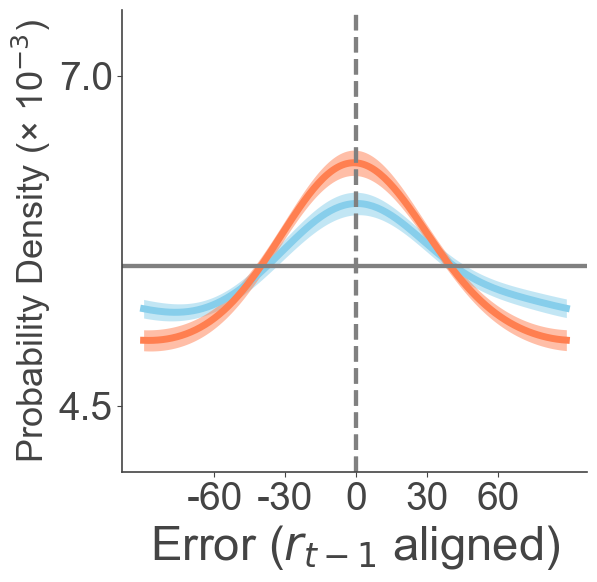

In [64]:
draw_lmb = lambda df: (df['mode'] == 'draw').to_numpy()
click_lmb = lambda df: (df['mode'] == 'click').to_numpy()

fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'draw': {
        'target': 'combined',
        'lmb': draw_lmb,
        'plot_settings': {
            'plot_line_color': MODE_COLOR_MAPPINGS['draw'],
            'plot_line_style': '-',
            'plot_line_alpha': 1,
        },
    },
    'click': {
        'target': 'combined',
        'lmb': click_lmb,
        'plot_settings': {
            'plot_line_color': MODE_COLOR_MAPPINGS['click'],
            'plot_line_style': '-',
            'plot_line_alpha': 1,
        },
    },
}
_, stats_results = display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='sd', 
    common_lmb=has_valid_prev_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb,
    return_subj_stats=True)
display_ttest_rel2_results(stats_results, ['draw', 'click'])
# ax.set_title('full delay phase sd bias: draw&click', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_modes_sd.png')
plt.savefig(plot_path, bbox_inches='tight')

bias: t(35)=-2.41 (p=0.021)


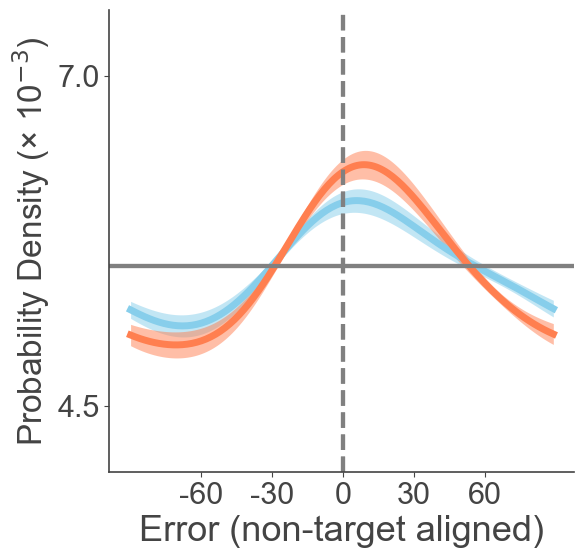

In [65]:
draw_lmb = lambda df: (df['mode'] == 'draw').to_numpy()
click_lmb = lambda df: (df['mode'] == 'click').to_numpy()

fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'draw': {
        'target': 'combined',
        'lmb': draw_lmb,
        'plot_settings': {
            'plot_line_color': MODE_COLOR_MAPPINGS['draw'],
            'plot_line_style': '-',
            'plot_line_alpha': 1,
        },
    },
    'click': {
        'target': 'combined',
        'lmb': click_lmb,
        'plot_settings': {
            'plot_line_color': MODE_COLOR_MAPPINGS['click'],
            'plot_line_style': '-',
            'plot_line_alpha': 1,
        },
    },
}
_, stats_results = display_stats_and_distrib(ax,
    full_delay_phase_results,
    stats_type='sur', 
    common_lmb=None, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb,
    return_subj_stats=True,
    zoom_out=False
)
display_ttest_rel2_results(stats_results, ['draw', 'click'])
# ax.set_title('full delay phase sur bias: draw&click', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_modes_sur.png')
plt.savefig(plot_path, bbox_inches='tight')

##### Comments:
- Decoding accuracy is impacted by both (1) sequential order of presentation and (2) the feature distance between current and previous item. This speaks to RSA results, serves as another indirect evidence that perceptual history serves to 'stabilize' the system
- But why we do not see significant bias overall? Here we have concatenated data across the whole 5 seconds delay; following analysis will show the direction of bias change over time...

### Train & test across modes

In [67]:
draw_delay_lmb = lambda df: (df['mode'] == 'draw').to_numpy()
click_delay_lmb = lambda df: (df['mode'] == 'click').to_numpy()
mode_lmbs = {
    'draw': draw_delay_lmb,
    'click': click_delay_lmb,
}

In [68]:
all_delay_across_modes = {}
item_weights_lmb = lambda df: convert_df_to_delay_design_matrix(df)
for train_mode in ['draw', 'click']:
    for test_mode in ['draw', 'click']:
        print(f'Trained on {train_mode}, tested on {test_mode}')
        n_subjects = len(all_subjs)
        train_lmb = mode_lmbs[train_mode]
        test_lmb = mode_lmbs[test_mode]
        modes_delay_phase_results = cv_train_test_invert_encoding(
            DEFAULT_FORWARD_MODEL_PARAMS, 
            delay_phase, delay_phase, 
            ['stim_1', 'stim_2'], ['stim_1', 'stim_2'], 
            train_lmb, test_lmb, 
            item_weights_lmb, n_subjects)
        all_delay_across_modes[(train_mode, test_mode)] = modes_delay_phase_results

Trained on draw, tested on draw
Trained on draw, tested on click
Trained on click, tested on draw
Trained on click, tested on click


In [69]:
mode_prev_lmbs = {
    'draw': lambda df: draw_lmb(df) & has_valid_prev_lmb(df),
    'click': lambda df: click_lmb(df) & has_valid_prev_lmb(df),
}

#### For simplicity: combining N=1 and N=2

In [70]:
def keep_share_axis_only(axs):
    nr,nc = axs.shape
    for i in range(nr):
        for j in range(nc):
            if i != nr-1:
                axs[i,j].set_xticks([])
                axs[i,j].set_xlabel('')
            if j != 0:
                axs[i,j].set_yticks([])
                axs[i,j].set_ylabel('')


draw -> draw
draw -> click
click -> draw
click -> click


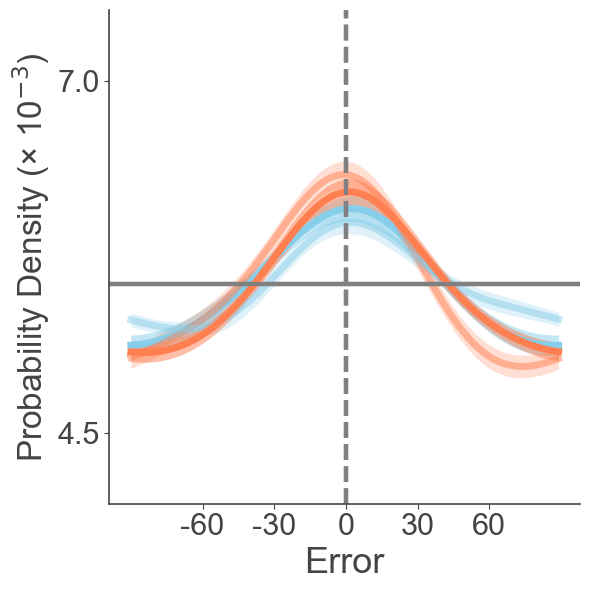

In [71]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
across_modes_acc_stats = {}
for i, train_mode in enumerate(['draw', 'click']):
    for j, test_mode in enumerate(['draw', 'click']):
        print(f'{train_mode} -> {test_mode}')
        results = all_delay_across_modes[(train_mode, test_mode)]
        test_lmb = mode_lmbs[test_mode]

        # specific plot settings
        mode_cond_name = f'{train_mode}->{test_mode}'
        plot_alpha = 1 if test_mode == train_mode else 0.5
        plot_settings = {
            mode_cond_name: {
                'target': 'combined',
                'lmb': None,
                'plot_settings': {
                    'plot_line_color': MODE_COLOR_MAPPINGS[test_mode],
                    'plot_line_style': '-',
                    'plot_line_alpha': plot_alpha,
                },
            },
        }

        _, stats_results = display_stats_and_distrib(ax,
            results,
            stats_type='accuracy', 
            common_lmb=test_lmb, condition_lmbs=plot_settings,
            item_weights_lmb=item_weights_lmb,
            return_subj_stats=True,
            zoom_out=False)
        stats_results = stats_results[mode_cond_name]
        across_modes_acc_stats[f'{train_mode}->{test_mode}'] = stats_results

plt.tight_layout()
plot_path = os.path.join(PLOTS_FOLDER, 'single_or_both_delay_decoded_cross_modes_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

In [72]:
from utils.inverted_encoding import anova_within_subject_test

In [73]:
_ = anova_within_subject_test(across_modes_acc_stats, 'accuracy')

                 Anova
          F Value Num DF  Den DF  Pr > F
----------------------------------------
condition  4.4624 3.0000 105.0000 0.0054

                    comparison  t_stat   p_val
0    draw->draw vs draw->click   269.0  0.3226
1    draw->draw vs click->draw   215.0  0.0644
2   draw->draw vs click->click   286.0  0.4697
3   draw->click vs click->draw   155.0  0.0044
4  draw->click vs click->click   285.0  0.4601
5  click->draw vs click->click   203.0  0.0409


In [74]:
mode_separate_acc_stats = {
    'draw': across_modes_acc_stats['draw->draw'],
    'click': across_modes_acc_stats['draw->click'],
}
display_ttest_rel2_results(
    mode_separate_acc_stats, ['draw', 'click'])

accuracy: W=284, n=36 (p=0.451)
bias: t(35)=0.66 (p=0.515)


In [75]:
mode_separate_acc_stats = {
    'draw': across_modes_acc_stats['click->draw'],
    'click': across_modes_acc_stats['click->click'],
}
display_ttest_rel2_results(
    mode_separate_acc_stats, ['draw', 'click'])

accuracy: t(35)=-2.44 (p=0.020)
bias: t(35)=-0.10 (p=0.919)


draw -> draw
draw -> click
click -> draw
click -> click


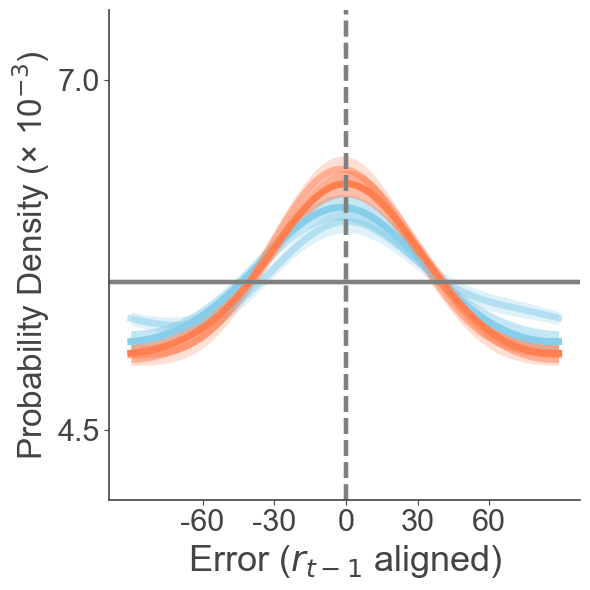

In [76]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
across_modes_sd_stats = {}
for i, train_mode in enumerate(['draw', 'click']):
    for j, test_mode in enumerate(['draw', 'click']):
        print(f'{train_mode} -> {test_mode}')
        results = all_delay_across_modes[(train_mode, test_mode)]
        test_lmb = mode_prev_lmbs[test_mode]

        # specific plot settings
        mode_cond_name = f'{train_mode}->{test_mode}'
        plot_alpha = 1 if test_mode == train_mode else 0.5
        plot_settings = {
            mode_cond_name: {
                'target': 'combined',
                'lmb': None,
                'plot_settings': {
                    'plot_line_color': MODE_COLOR_MAPPINGS[test_mode],
                    'plot_line_style': '-',
                    'plot_line_alpha': plot_alpha,
                },
            },
        }

        _, stats_results = display_stats_and_distrib(ax,
            results,
            stats_type='sd', 
            common_lmb=test_lmb, condition_lmbs=plot_settings,
            item_weights_lmb=item_weights_lmb,
            return_subj_stats=True,
            zoom_out=False)
        stats_results = stats_results[mode_cond_name]
        across_modes_sd_stats[f'{train_mode}->{test_mode}'] = stats_results

plt.tight_layout()
plot_path = os.path.join(PLOTS_FOLDER, 'single_or_both_delay_decoded_cross_modes_sd.png')
plt.savefig(plot_path, bbox_inches='tight')

In [77]:
_ = anova_within_subject_test(across_modes_sd_stats, 'bias')

                 Anova
          F Value Num DF  Den DF  Pr > F
----------------------------------------
condition  0.4103 3.0000 105.0000 0.7459

                    comparison  t_stat   p_val
0    draw->draw vs draw->click   282.0  0.4321
1    draw->draw vs click->draw   332.0  0.9938
2   draw->draw vs click->click   301.0  0.6247
3   draw->click vs click->draw   311.0  0.7386
4  draw->click vs click->click   252.0  0.2087
5  click->draw vs click->click   307.0  0.6922


#### Store subject accuracy

In [78]:
def store_subject_stats(results, common_lmb, condition_lmbs, stats_type, cond_name,
        item_weights_lmb=item_weights_lmb, sharpness=delay_best_sharpness):
    # collect subject level stats
    stats_results = display_stats_and_distrib(
        ax=None,
        results=results, 
        stats_type=stats_type, 
        common_lmb=common_lmb, 
        condition_lmbs=condition_lmbs, 
        item_weights_lmb=item_weights_lmb, 
        sharpness=sharpness,
        return_subj_stats=True # need subject wise stats
    )
    stats_results = stats_results[1] # fetch only subject level stats

    # store it
    sub_result_folder = os.path.join(PROCESSED_FOLDER, f'{cond_name}')
    os.makedirs(sub_result_folder, exist_ok=True)
    result_path = os.path.join(sub_result_folder, f'{stats_type}.json')
    with open(result_path, 'w') as f: 
        json.dump(stats_results, f, indent=4)

##### store subject accuracy during drawing v.s. clicking tasks

In [79]:
for mode in ['draw', 'click']:
    test_lmb = mode_lmbs[mode]
    stat_extract_settings = {
        'stim 1': {
            'target': 'stim 1',
            'lmb': stim1_valid_lmb,
        },
        'stim 2': {
            'target': 'stim 2',
            'lmb': stim2_valid_lmb,
        },
        'combined': {
            'target': 'combined',
            'lmb': None,
        },
    }
    for stats_type in ['accuracy', 'sd', 'sur']:
        print(f'Saving {mode} {stats_type} stats')
        common_lmb = test_lmb
        if stats_type == 'sd':
            common_lmb = mode_prev_lmbs[mode]
        store_subject_stats(
            all_delay_across_modes[(mode, mode)], 
            common_lmb, 
            stat_extract_settings, 
            stats_type, 
            f'whole_delay_{mode}2{mode}',
            item_weights_lmb=item_weights_lmb,
            sharpness=delay_best_sharpness)
    

Saving draw accuracy stats
Saving draw sd stats
Saving draw sur stats
Saving click accuracy stats
Saving click sd stats
Saving click sur stats


##### (Exp): can we see cardinal / oblique bias in prediction?

In [80]:
def get_stim_restrict_bias(results, common_lmb, center_sample, window_size,
        item_weights_lmb=item_weights_lmb, to_fetch='combined', sharpness=delay_best_sharpness):
    stim1_within_range_lmb = lambda df: (
        stim1_valid_lmb(df) &
        (np.abs(deg_signed_diff(df['stim_1'].values -center_sample)) <= window_size))
    stim2_within_range_lmb = lambda df: (
        stim2_valid_lmb(df) &
        (np.abs(deg_signed_diff(df['stim_2'].values - center_sample)) <= window_size))
    at_least_one_within_lmb = lambda df: (
        stim1_within_range_lmb(df) | stim2_within_range_lmb(df))

    plot_settings = {
        'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_within_range_lmb,
        },
        'stim 2': {
            'target': 'stim 2',
            'lmb': stim2_within_range_lmb,
        },
        'combined': {
            'target': 'combined',
            'lmb': at_least_one_within_lmb,
        },
    }
        
    stats = display_stats_and_distrib(
        ax=None, results=results, stats_type='accuracy', 
        common_lmb=common_lmb, condition_lmbs=plot_settings, 
        item_weights_lmb=item_weights_lmb,
        sharpness=sharpness)   

    # only fetch the acc and bias from the combined
    stats = stats[to_fetch]
    return stats

In [81]:
def display_acc_bias_as_tuning(results, common_lmb, condition_name,
        item_weights_lmb=item_weights_lmb,
        to_fetch='combined', sharpness=delay_best_sharpness):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    sample_step = 15
    sample_xs = np.arange(int(180/sample_step)) * sample_step
    collected_sample_stats = []
    for sample_x in sample_xs:
        stats = get_stim_restrict_bias(
            results,
            common_lmb=common_lmb,
            center_sample=sample_x,
            window_size=sample_step,
            item_weights_lmb=item_weights_lmb,
            to_fetch=to_fetch,
            sharpness=sharpness
        )
        collected_sample_stats.append(stats)

    # make it wrap around
    sample_xs = np.append(sample_xs, 180)
    collected_sample_stats.append(collected_sample_stats[0])
        
    for i, stat_name in enumerate(['accuracy', 'bias']):
        stats_mean = np.array([
            collected_sample_stats[i][stat_name]['mean'] for i in range(len(sample_xs))])
        stats_sem = np.array([
            collected_sample_stats[i][stat_name]['sem'] for i in range(len(sample_xs))])
        axs[i].errorbar(sample_xs, stats_mean, yerr=stats_sem, fmt='o', capsize=5)

        axs[i].set_xlabel('Stim Degree')
        axs[i].axvline(45, color='gray', linestyle='--', alpha=0.5)
        axs[i].axvline(90, color='gray', linestyle='--')
        axs[i].axvline(135, color='gray', linestyle='--', alpha=0.5)
        axs[i].axhline(0, color='red', linestyle='--')

        axs[i].set_xticks(sample_xs)

    axs[0].set_ylim([-1.0, 2.0])
    axs[0].set_yticks(np.arange(-0.5, 2.0, 0.5))
    axs[0].set_ylabel('evidence', fontsize=14)
    axs[1].set_ylim([-0.1, 0.1])
    axs[1].set_yticks(np.arange(-0.08, 0.1, 0.02))
    axs[1].set_ylabel('bias', fontsize=14)

    # save the figure
    plot_path = os.path.join(PLOTS_FOLDER, f'{condition_name}_decoded_tuning_func.png')
    plt.savefig(plot_path, bbox_inches='tight')



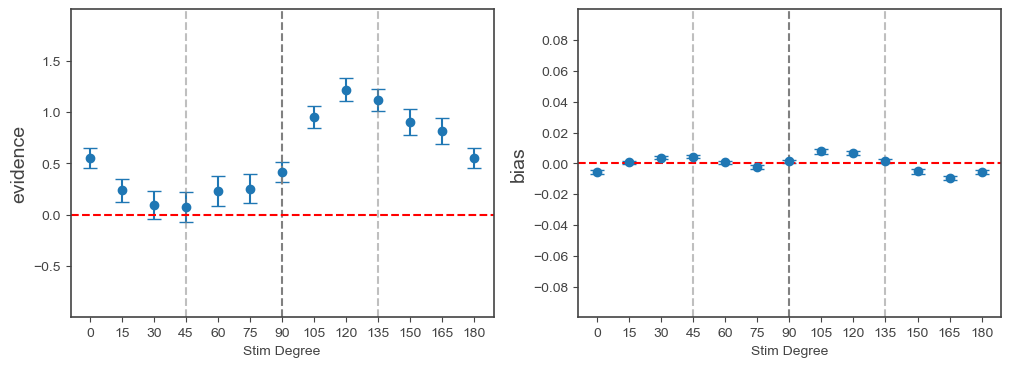

In [82]:
default_lmb = lambda df: np.ones(len(df), dtype=bool)
display_acc_bias_as_tuning(
    results=full_delay_phase_results,
    common_lmb=default_lmb, condition_name='all_delay')

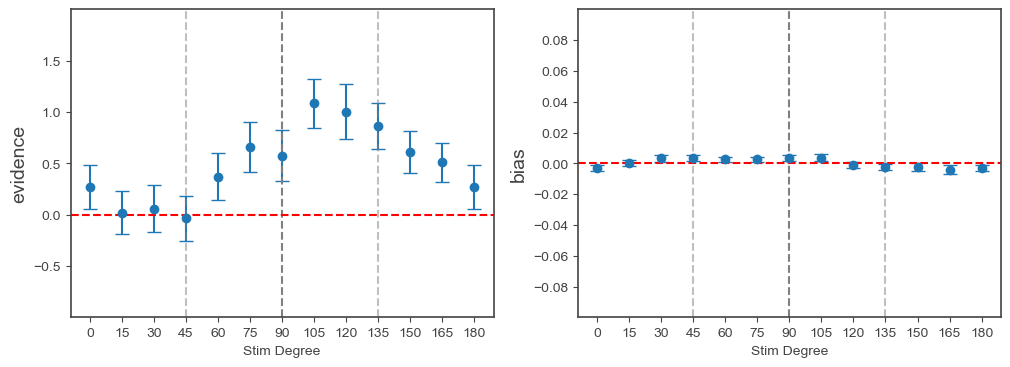

In [83]:
display_acc_bias_as_tuning(
    results=all_delay_across_modes[('draw', 'draw')],
    common_lmb=draw_lmb, condition_name='draw_delay')

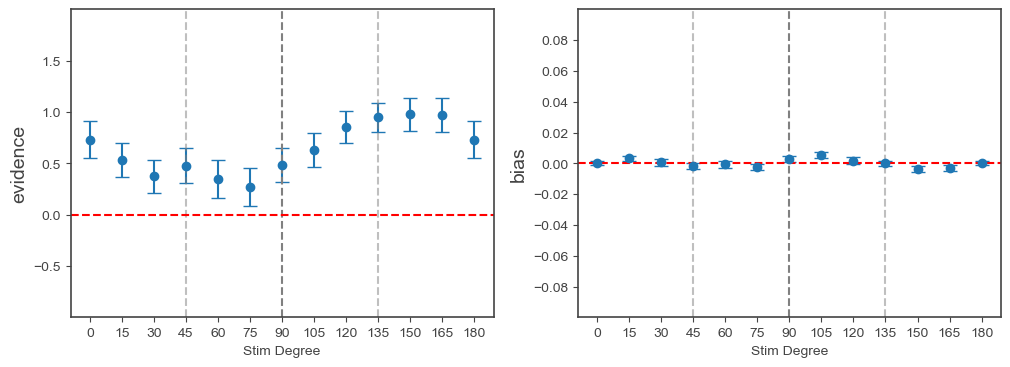

In [84]:
display_acc_bias_as_tuning(
    results=all_delay_across_modes[('click', 'click')],
    common_lmb=click_lmb, condition_name='click_delay')

##### What about ISI

In [85]:
from copy import deepcopy

DEFAULT_ISI_FORWARD_MODEL_PARAMS = deepcopy(DEFAULT_FORWARD_MODEL_PARAMS)
DEFAULT_ISI_FORWARD_MODEL_PARAMS['forward']['sharpness'] = ISI_best_sharpness


In [86]:
valid_isi_lmb = lambda df: ((df['trial_code'] == 1) | (df['stim_1_to_report'])).to_numpy()
isi_item_weights_lmb = lambda df: np.array([
    np.ones(len(df)),
    np.zeros(len(df)),
]).T
isi_decode_results = cv_train_test_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    ISI_phase, ISI_phase, 
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, valid_isi_lmb,
    isi_item_weights_lmb, n_subjects)

--- accuracy ---
        mean    sem  t_stat   p_val  df
stim 1  1.09  0.157  6.9565  0.0000  35
stim 2  0.07  0.072  0.9724  0.1688  35
--- bias ---
         mean  sem (1e-3)  w_stat   p_val     n  t_stat    df
stim 1  0.026       0.103   318.0  0.5950  36.0     NaN   NaN
stim 2 -0.018       0.064     NaN  0.6102   NaN  -0.282  35.0


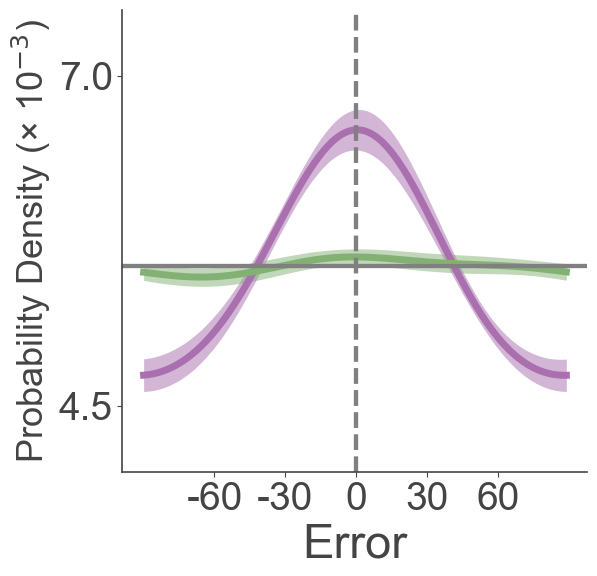

In [87]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
}

default_item_weights_lmb = lambda df: np.array([
    np.ones(len(df))/2,
    np.ones(len(df))/2,
]).T

stats_results = display_stats_and_distrib(ax,
    isi_decode_results,
    stats_type='accuracy', 
    common_lmb=valid_isi_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=default_item_weights_lmb, # assuming taking all?
    sharpness=ISI_best_sharpness
)

print_stats_results_as_tables(stats_results)
plot_path = os.path.join(PLOTS_FOLDER, 'isi_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

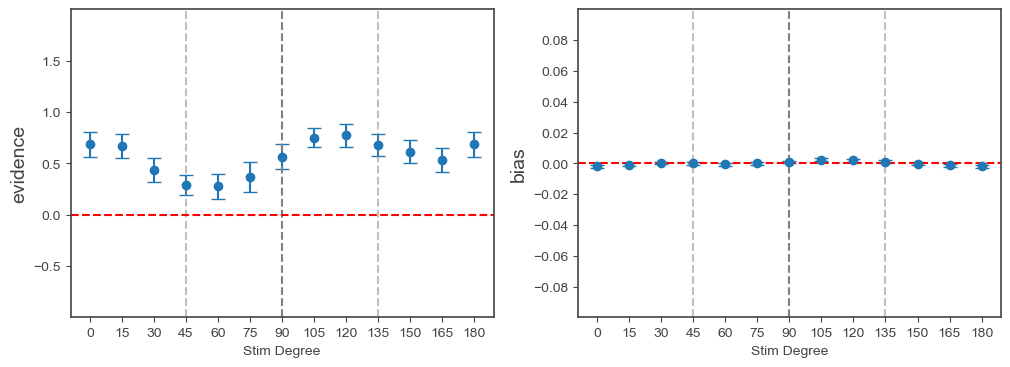

In [88]:
display_acc_bias_as_tuning(
    results=isi_decode_results,
    common_lmb=valid_isi_lmb, condition_name='isi',
    item_weights_lmb=isi_item_weights_lmb,
    to_fetch='stim 1',
    sharpness=ISI_best_sharpness)

#### And post-encoding phases

In [89]:
post_enc1_phase = np.arange(start=1750//50, stop=2250//50).astype(int)
post_enc2_phase = np.arange(start=4000//50, stop=4500//50).astype(int)

In [90]:
post_enc1_decode_results = cv_train_test_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    post_enc1_phase, post_enc1_phase, 
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, valid_isi_lmb,
    isi_item_weights_lmb, n_subjects)

--- accuracy ---
         mean    sem  t_stat   p_val  df
stim 1  1.434  0.193  7.4280  0.0000  35
stim 2  0.066  0.073  0.8997  0.1872  35
--- bias ---
         mean  sem (1e-3)  t_stat   p_val    df  w_stat     n
stim 1  0.070       0.128  0.5446  0.2947  35.0     NaN   NaN
stim 2  0.109       0.065     NaN  0.0558   NaN   435.0  36.0


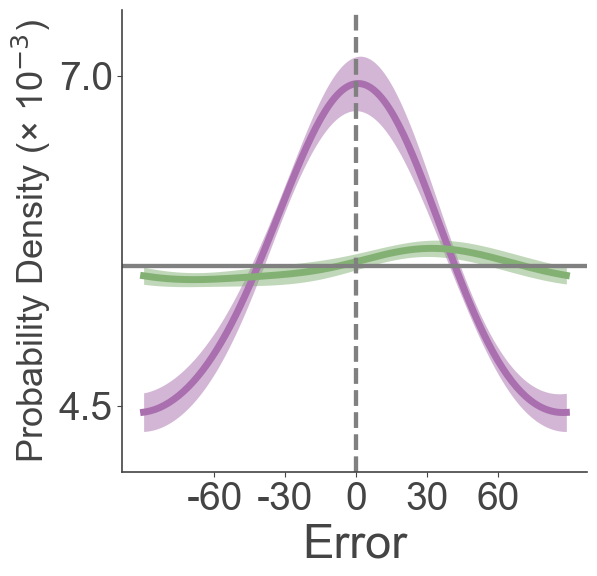

In [91]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
}

default_item_weights_lmb = lambda df: np.array([
    np.ones(len(df))/2,
    np.ones(len(df))/2,
]).T

stats_results = display_stats_and_distrib(ax,
    post_enc1_decode_results,
    stats_type='accuracy', 
    common_lmb=valid_isi_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=default_item_weights_lmb, # assuming taking all?
    sharpness=ISI_best_sharpness
)

print_stats_results_as_tables(stats_results)
plot_path = os.path.join(PLOTS_FOLDER, 'post_enc1_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')


In [92]:
post_enc2_decode_results = cv_train_test_invert_encoding(
    DEFAULT_FORWARD_MODEL_PARAMS, 
    post_enc2_phase, post_enc2_phase, 
    ['stim_1', 'stim_2' ], ['stim_1', 'stim_2'], 
    None, None,
    item_weights_lmb, n_subjects)

--- accuracy ---
           mean    sem  w_stat  p_val   n
stim 1    0.387  0.075   609.0    0.0  36
stim 2    0.730  0.115   662.0    0.0  36
combined  0.561  0.078   661.0    0.0  36
--- bias ---
           mean  sem (1e-3)  t_stat   p_val  df
stim 1   -0.068       0.070 -0.9685  0.8303  35
stim 2    0.096       0.094  1.0207  0.1572  35
combined  0.026       0.068  0.3796  0.3533  35


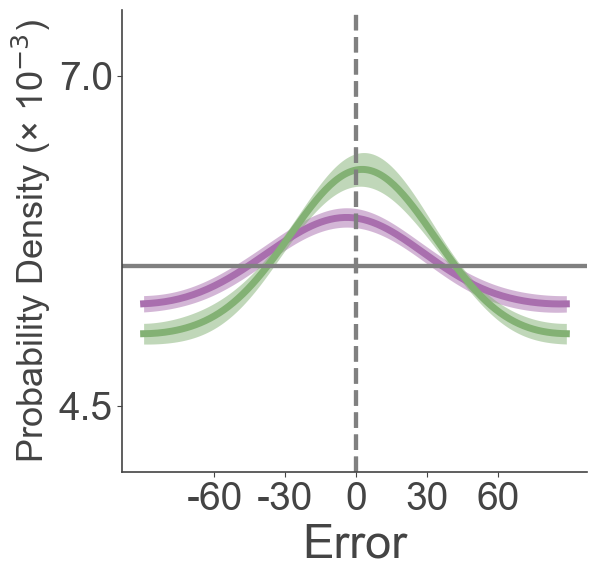

In [93]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
        'to_plot': False,
    },
}
stats_results = display_stats_and_distrib(ax,
    post_enc2_decode_results,
    stats_type='accuracy', 
    common_lmb=None, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
# print(stats_results)
print_stats_results_as_tables(stats_results)
# ax.set_title('Errors: full delay phase', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'post_enc2_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')


##### Also store the combined ISI v.s. Full-delay results

In [94]:
## isi
stat_extract_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'draw': {
        'target': 'stim 1',
        'lmb': draw_lmb,
    },
    'click': {
        'target': 'stim 1',
        'lmb': click_lmb,
    },
}

for stats_type in ['accuracy', 'sd', 'sur']:
    print(f'Saving {mode} {stats_type} stats')
    common_lmb = valid_isi_lmb
    if stats_type == 'sd':
        common_lmb = lambda d: valid_isi_lmb(d) & has_valid_prev_lmb(d)
    store_subject_stats(
        isi_decode_results, 
        common_lmb, 
        stat_extract_settings, 
        stats_type, 
        f'whole_isi_combined',
        item_weights_lmb=isi_item_weights_lmb,
        sharpness=ISI_best_sharpness)
    

Saving click accuracy stats
Saving click sd stats
Saving click sur stats


In [95]:
## delay
stat_extract_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
    'draw': {
        'target': 'combined',
        'lmb': draw_lmb,
    },
    'click': {
        'target': 'combined',
        'lmb': click_lmb,
    },
}

for stats_type in ['accuracy', 'sd', 'sur']:
    print(f'Saving {stats_type} stats')
    common_lmb = None
    if stats_type == 'sd':
        common_lmb = has_valid_prev_lmb
    store_subject_stats(
        full_delay_phase_results, 
        common_lmb, 
        stat_extract_settings, 
        stats_type, 
        f'whole_delay_combined',
        item_weights_lmb=item_weights_lmb,
        sharpness=delay_best_sharpness)
    

Saving accuracy stats
Saving sd stats
Saving sur stats


#### We also want to separate the stim that are easy or hard

In [96]:
VERTICAL_LMB = lambda d: (np.abs(deg_signed_diff(d-0)) <= 15)
HORIZONTAL_LMB = lambda d: (np.abs(deg_signed_diff(d-90)) <= 15)
UPPER_DIAG_LMB = lambda d: (np.abs(deg_signed_diff(d-45)) <= 15)
LOWER_DIAG_LMB = lambda d: (np.abs(deg_signed_diff(d-135)) <= 15)
UPPER_LMB = lambda d: (d < 90)
LOWER_LMB = lambda d: (d > 90)

angle_range_lmbs = {
    'diag': lambda d: ((UPPER_DIAG_LMB(d) | LOWER_DIAG_LMB(d))),
    'cardinal': lambda d: ((VERTICAL_LMB(d) | HORIZONTAL_LMB(d))),
    'upper': lambda d: UPPER_LMB(d),
    'lower': lambda d: LOWER_LMB(d),
    'vertical': lambda d: VERTICAL_LMB(d),
    'horizontal': lambda d: HORIZONTAL_LMB(d),
    'other': lambda d: (~((UPPER_DIAG_LMB(d)) | (LOWER_DIAG_LMB(d)) | (VERTICAL_LMB(d)) | (HORIZONTAL_LMB(d)))),
}

In [97]:
## delay
angle_stats_extract_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

angle_stats_folder = os.path.join(PROCESSED_FOLDER, 'whole_delay_angles')
os.makedirs(angle_stats_folder, exist_ok=True)
for stats_type in ['accuracy', 'sd', 'sur']:
    # for each stats
    print(f'Saving {stats_type} stats')
    angle_stats_combined = {}
    for angle_name, angle_lmb in angle_range_lmbs.items():
        angle_stim1_lmb = lambda df: (stim1_valid_lmb(df) & angle_lmb(df['stim_1'].values))
        angle_stim2_lmb = lambda df: (stim2_valid_lmb(df) & angle_lmb(df['stim_2'].values))
        angle_valid_lmb = lambda df: (angle_stim1_lmb(df) | angle_stim2_lmb(df))
        angle_stats_extract_settings = {
            'stim 1': {
                'target': 'stim 1',
                'lmb': angle_stim1_lmb,
            },
            'stim 2': {
                'target': 'stim 2',
                'lmb': angle_stim2_lmb,
            },
            'combined': {
                'target': 'combined',
                'lmb': angle_valid_lmb,
            },
        }

        common_lmb = None
        if stats_type == 'sd':
            common_lmb = has_valid_prev_lmb

        # extract stats
        _, stats_results = display_stats_and_distrib(
            ax=None,
            results=full_delay_phase_results, 
            stats_type=stats_type, 
            common_lmb=common_lmb, 
            condition_lmbs=angle_stats_extract_settings, 
            item_weights_lmb=item_weights_lmb, 
            sharpness=delay_best_sharpness,
            return_subj_stats=True # need subject wise stats
        )

        # take only the one we are interested in
        angle_stats_combined[angle_name] = stats_results['combined']

    result_path = os.path.join(angle_stats_folder, f'{stats_type}.json')
    with open(result_path, 'w') as f: 
        json.dump(angle_stats_combined, f, indent=4)


Saving accuracy stats
Saving sd stats
Saving sur stats


### Finally, how well could ISI pattern generalized to the delay pattern?

In [98]:
isi_delay_decode_results = cv_train_test_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    ISI_phase, delay_phase, 
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, None,
    isi_item_weights_lmb, n_subjects)

--- accuracy ---
           mean    sem  t_stat  p_val    df  w_stat     n
stim 1    1.023  0.107  9.5647    0.0  35.0     NaN   NaN
stim 2    0.701  0.129     NaN    0.0   NaN   614.0  36.0
combined  0.870  0.095  9.1975    0.0  35.0     NaN   NaN
--- bias ---
           mean  sem (1e-3)  t_stat   p_val  df
stim 1    0.082       0.094  0.8759  0.1935  35
stim 2    0.138       0.076  1.8176  0.0389  35
combined  0.103       0.062  1.6548  0.0535  35


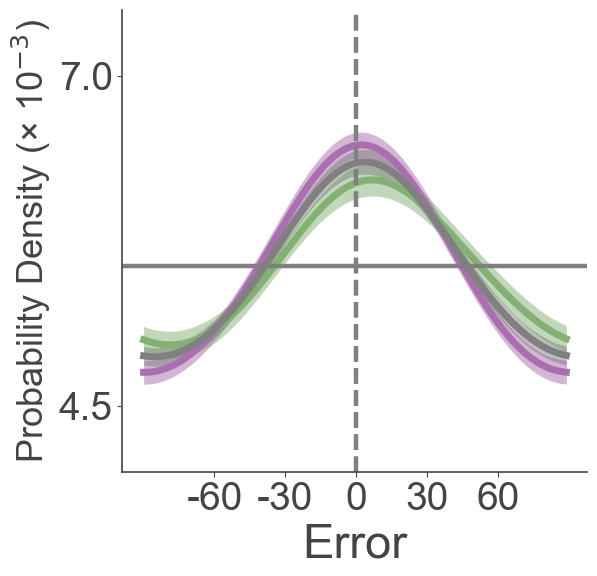

In [99]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

stats_results=display_stats_and_distrib(ax,
    isi_delay_decode_results,
    stats_type='accuracy', 
    common_lmb=None, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb, # assuming taking all?
    sharpness=delay_best_sharpness
)
print_stats_results_as_tables(stats_results)
plot_path = os.path.join(PLOTS_FOLDER, 'isi_delay_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

In [100]:
stat_extract_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

for stats_type in ['accuracy', 'sd', 'sur']:
    print(f'Saving {mode} {stats_type} stats')
    common_lmb = None
    if stats_type == 'sd':
        common_lmb = has_valid_prev_lmb
    store_subject_stats(
        isi_delay_decode_results, 
        common_lmb, 
        stat_extract_settings, 
        stats_type, 
        f'isi_delay_combined',
        item_weights_lmb=item_weights_lmb,
        sharpness=delay_best_sharpness)

Saving click accuracy stats
Saving click sd stats
Saving click sur stats


#### Exploration: is it possible to decode the pattern from encoding phase gaze?

In [101]:
enc1_phase = np.arange(start=1000//50, stop=1750//50).astype(int)

In [102]:
enc1_decode_results = cv_train_test_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    enc1_phase, enc1_phase, 
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, valid_isi_lmb,
    isi_item_weights_lmb, n_subjects)

--- accuracy ---
         mean    sem  w_stat   p_val     n  t_stat    df
stim 1  0.582  0.116   612.0  0.0000  36.0     NaN   NaN
stim 2 -0.008  0.066     NaN  0.5509   NaN -0.1287  35.0
--- bias ---
         mean  sem (1e-3)  t_stat   p_val  df
stim 1 -0.012       0.071 -0.1646  0.5649  35
stim 2  0.130       0.057  2.2725  0.0147  35


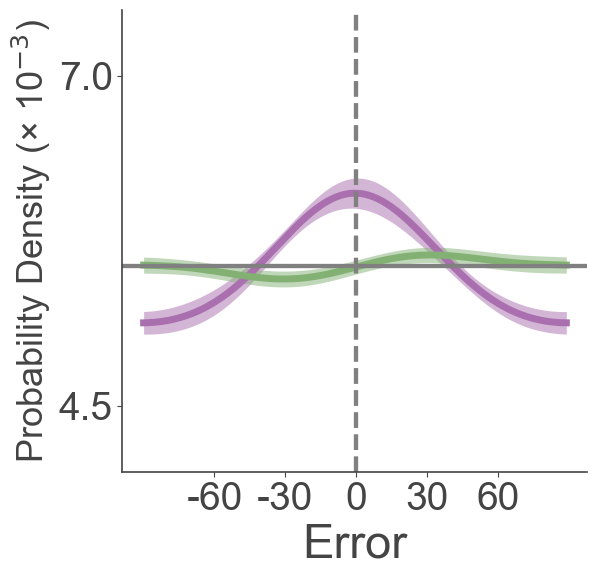

In [103]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
}

default_item_weights_lmb = lambda df: np.array([
    np.ones(len(df))/2,
    np.ones(len(df))/2,
]).T

stats_results=display_stats_and_distrib(ax,
    enc1_decode_results,
    stats_type='accuracy', 
    common_lmb=valid_isi_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=default_item_weights_lmb, # assuming taking all?
    sharpness=ISI_best_sharpness
)
print_stats_results_as_tables(stats_results)

plot_path = os.path.join(PLOTS_FOLDER, 'enc1_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

##### further split the phase into before and after cue onset

In [104]:
enc1_phase_before_cue = np.arange(start=1000//50, stop=1250//50).astype(int)
enc1_phase_during_cue = np.arange(start=1250//50, stop=1500//50).astype(int)
enc1_phase_after_cue = np.arange(start=1500//50, stop=1750//50).astype(int)

In [105]:
enc1_decode_results_before_cue = cv_train_test_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    enc1_phase_before_cue, enc1_phase_before_cue, 
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, valid_isi_lmb,
    isi_item_weights_lmb, n_subjects)

--- accuracy ---
         mean    sem  t_stat   p_val  df
stim 1 -0.092  0.081 -1.1408  0.8691  35
stim 2 -0.012  0.087 -0.1412  0.5557  35
--- bias ---
         mean  sem (1e-3)  t_stat   p_val  df
stim 1  0.047       0.056  0.8360  0.2044  35
stim 2  0.064       0.062  1.0315  0.1547  35


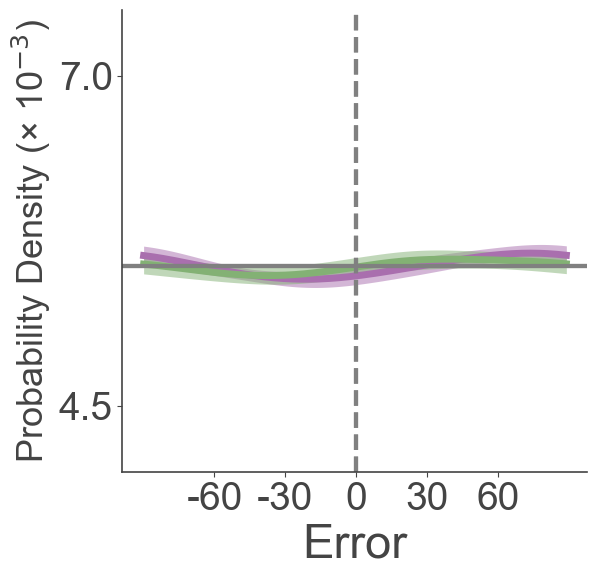

In [106]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
}

default_item_weights_lmb = lambda df: np.array([
    np.ones(len(df))/2,
    np.ones(len(df))/2,
]).T

stats_results = display_stats_and_distrib(ax,
    enc1_decode_results_before_cue,
    stats_type='accuracy', 
    common_lmb=valid_isi_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=default_item_weights_lmb, # assuming taking all?
    sharpness=ISI_best_sharpness
)
print_stats_results_as_tables(stats_results)

plot_path = os.path.join(PLOTS_FOLDER, 'enc1_before_cue_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

In [107]:
enc1_decode_results_during_cue = cv_train_test_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    enc1_phase_during_cue, enc1_phase_during_cue, 
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, valid_isi_lmb,
    isi_item_weights_lmb, n_subjects)

--- accuracy ---
         mean    sem  t_stat   p_val  df
stim 1  0.129  0.092  1.4021  0.0848  35
stim 2  0.075  0.108  0.6877  0.2481  35
--- bias ---
         mean  sem (1e-3)  t_stat   p_val  df
stim 1 -0.028       0.061 -0.4619  0.6765  35
stim 2 -0.062       0.070 -0.8767  0.8067  35


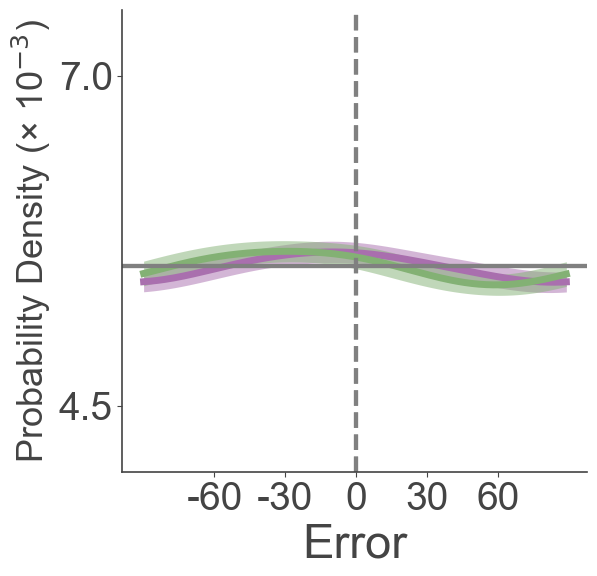

In [108]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
}

default_item_weights_lmb = lambda df: np.array([
    np.ones(len(df))/2,
    np.ones(len(df))/2,
]).T

stats_results = display_stats_and_distrib(ax,
    enc1_decode_results_during_cue,
    stats_type='accuracy', 
    common_lmb=valid_isi_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=default_item_weights_lmb, # assuming taking all?
    sharpness=ISI_best_sharpness
)
print_stats_results_as_tables(stats_results)

plot_path = os.path.join(PLOTS_FOLDER, 'enc1_during_cue_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

In [109]:
enc1_decode_results_after_cue = cv_train_test_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    enc1_phase_after_cue, enc1_phase_after_cue, 
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, valid_isi_lmb,
    isi_item_weights_lmb, n_subjects)

--- accuracy ---
         mean    sem  t_stat   p_val  df
stim 1  1.087  0.154  7.0352  0.0000  35
stim 2  0.053  0.065  0.8206  0.2087  35
--- bias ---
         mean  sem (1e-3)  t_stat   p_val  df
stim 1  0.014       0.106  0.1276  0.4496  35
stim 2 -0.013       0.051 -0.2525  0.5990  35


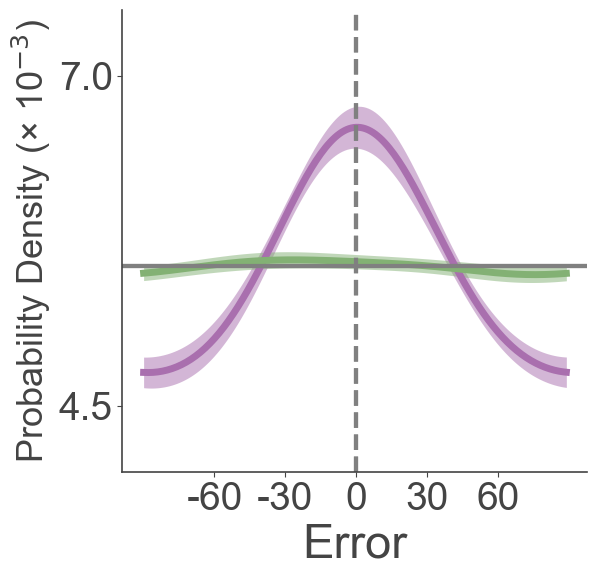

In [110]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
}

default_item_weights_lmb = lambda df: np.array([
    np.ones(len(df))/2,
    np.ones(len(df))/2,
]).T

stats_results = display_stats_and_distrib(ax,
    enc1_decode_results_after_cue,
    stats_type='accuracy', 
    common_lmb=valid_isi_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=default_item_weights_lmb, # assuming taking all?
    sharpness=ISI_best_sharpness
)
print_stats_results_as_tables(stats_results)

plot_path = os.path.join(PLOTS_FOLDER, 'enc1_after_cue_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

In [111]:
## isi
stat_extract_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
}

for stats_type in ['accuracy', 'sd', 'sur']:
    print(f'Saving {mode} {stats_type} stats')
    common_lmb = valid_isi_lmb
    if stats_type == 'sd':
        common_lmb = lambda d: valid_isi_lmb(d) & has_valid_prev_lmb(d)
    store_subject_stats(
        enc1_decode_results_before_cue, 
        common_lmb, 
        stat_extract_settings, 
        stats_type, 
        f'enc1_before_cue_combined',
        item_weights_lmb=isi_item_weights_lmb,
        sharpness=ISI_best_sharpness)
    
for stats_type in ['accuracy', 'sd', 'sur']:
    print(f'Saving {mode} {stats_type} stats')
    common_lmb = valid_isi_lmb
    if stats_type == 'sd':
        common_lmb = lambda d: valid_isi_lmb(d) & has_valid_prev_lmb(d)
    store_subject_stats(
        enc1_decode_results_after_cue, 
        common_lmb, 
        stat_extract_settings, 
        stats_type, 
        f'enc1_after_cue_combined',
        item_weights_lmb=isi_item_weights_lmb,
        sharpness=ISI_best_sharpness)

Saving click accuracy stats
Saving click sd stats
Saving click sur stats
Saving click accuracy stats
Saving click sd stats
Saving click sur stats


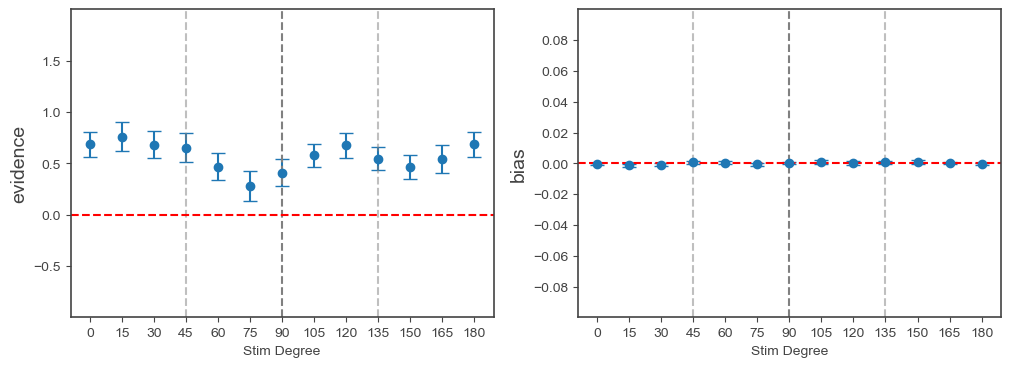

In [112]:
display_acc_bias_as_tuning(
    results=enc1_decode_results_after_cue,
    common_lmb=valid_isi_lmb, condition_name='enc',
    item_weights_lmb=isi_item_weights_lmb,
    to_fetch='stim 1',
    sharpness=ISI_best_sharpness)

##### Does Encoding Gaze pattern generalize to later phase?

In [113]:
enc1_isi_decode_results = cv_train_test_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    enc1_phase_after_cue, ISI_phase,
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, valid_isi_lmb,
    isi_item_weights_lmb, n_subjects)

--- accuracy ---
         mean    sem  t_stat   p_val  df
stim 1  0.788  0.137  5.7725  0.0000  35
stim 2 -0.010  0.076 -0.1256  0.5496  35
--- bias ---
         mean  sem (1e-3)  t_stat   p_val  df
stim 1 -0.203       0.091 -2.2417  0.9843  35
stim 2  0.021       0.061  0.3416  0.3674  35


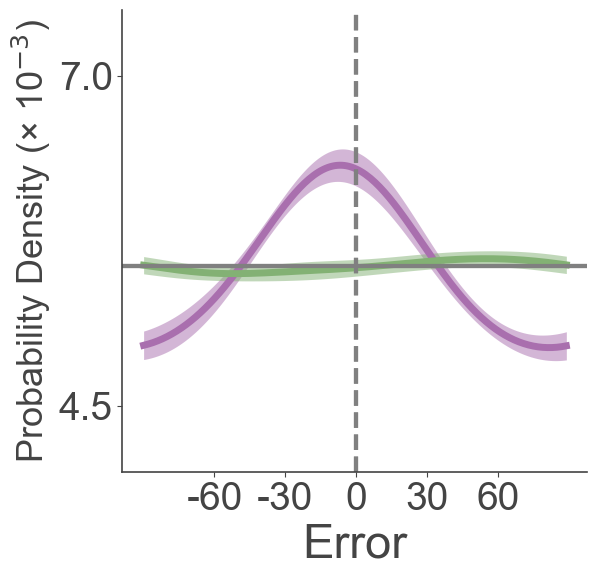

In [114]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
}

default_item_weights_lmb = lambda df: np.array([
    np.ones(len(df))/2,
    np.ones(len(df))/2,
]).T

stats_results = display_stats_and_distrib(ax,
    enc1_isi_decode_results,
    stats_type='accuracy', 
    common_lmb=valid_isi_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=default_item_weights_lmb, # assuming taking all?
    sharpness=ISI_best_sharpness
)
print_stats_results_as_tables(stats_results)
plot_path = os.path.join(PLOTS_FOLDER, 'enc1_isi_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

In [115]:
enc1_delay_decode_results = cv_train_test_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    enc1_phase_after_cue, delay_phase, 
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, None,
    isi_item_weights_lmb, n_subjects)

--- accuracy ---
           mean    sem  t_stat  p_val  df
stim 1    0.856  0.111  7.6794    0.0  35
stim 2    0.603  0.100  6.0116    0.0  35
combined  0.760  0.087  8.7689    0.0  35
--- bias ---
           mean  sem (1e-3)  t_stat   p_val    df  w_stat     n
stim 1   -0.178       0.078 -2.2698  0.9853  35.0     NaN   NaN
stim 2   -0.084       0.067 -1.2477  0.8898  35.0     NaN   NaN
combined -0.131       0.058     NaN  0.9722   NaN   212.0  36.0


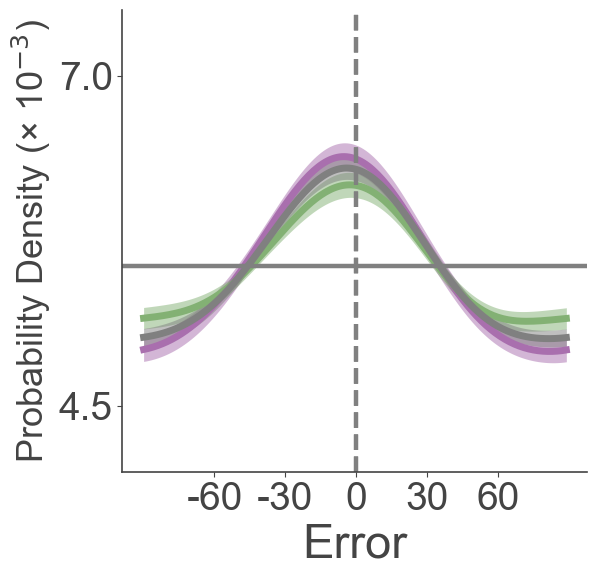

In [116]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

stats_results = display_stats_and_distrib(ax,
    enc1_delay_decode_results,
    stats_type='accuracy', 
    common_lmb=None, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb, # assuming taking all?
    sharpness=delay_best_sharpness
)
print_stats_results_as_tables(stats_results)

plot_path = os.path.join(PLOTS_FOLDER, 'enc1_delay_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

##### For comparision: get the late encoding result of stim 2

In [117]:
enc2_phase_after_cue = np.arange(start=3750//50, stop=4000//50).astype(int)

In [118]:
enc2_decode_results = cv_train_test_invert_encoding(
    DEFAULT_FORWARD_MODEL_PARAMS, 
    enc2_phase_after_cue, enc2_phase_after_cue, 
    ['stim_1', 'stim_2'], ['stim_1', 'stim_2'], 
    None, None,
    item_weights_lmb, n_subjects)

--- accuracy ---
           mean    sem  t_stat   p_val    df  w_stat     n
stim 1    0.378  0.086  4.3686  0.0001  35.0     NaN   NaN
stim 2    0.502  0.113     NaN  0.0000   NaN   598.0  36.0
combined  0.436  0.072     NaN  0.0000   NaN   633.0  36.0
--- bias ---
           mean  sem (1e-3)  w_stat   p_val     n  t_stat    df
stim 1   -0.048       0.078   265.0  0.8572  36.0     NaN   NaN
stim 2    0.094       0.090   422.0  0.0832  36.0     NaN   NaN
combined  0.034       0.068     NaN  0.3080   NaN  0.5061  35.0


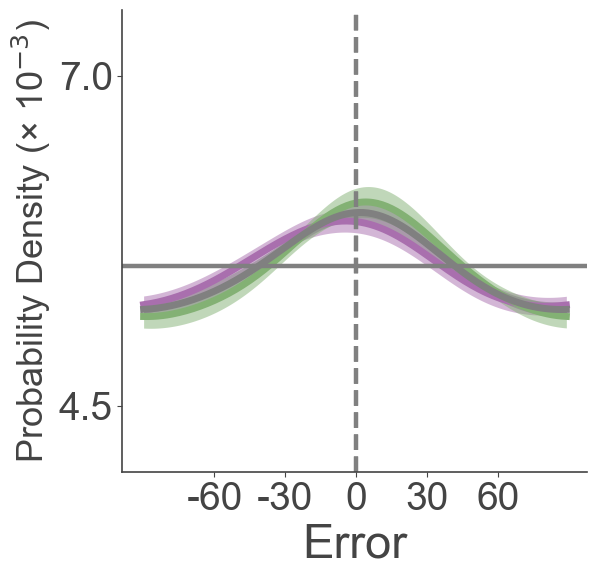

In [119]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}
stats_results = display_stats_and_distrib(ax,
    enc2_decode_results,
    stats_type='accuracy', 
    common_lmb=None, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb)
# print(stats_results)
print_stats_results_as_tables(stats_results)
# ax.set_title('Errors: full delay phase', fontsize=16)
plot_path = os.path.join(PLOTS_FOLDER, 'enc2_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')


##### store the results

In [120]:
# store enc1 -> isi
stat_extract_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
}

for stats_type in ['accuracy', 'sd', 'sur']:
    print(f'Saving {mode} {stats_type} stats')
    common_lmb = valid_isi_lmb
    if stats_type == 'sd':
        common_lmb = lambda d: valid_isi_lmb(d) & has_valid_prev_lmb(d)
    store_subject_stats(
        enc1_isi_decode_results, 
        common_lmb, 
        stat_extract_settings, 
        stats_type, 
        f'enc1_isi_combined',
        item_weights_lmb=isi_item_weights_lmb,
        sharpness=ISI_best_sharpness)
    

Saving click accuracy stats
Saving click sd stats
Saving click sur stats


In [121]:
# store enc1 -> delay
stat_extract_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

for stats_type in ['accuracy', 'sd', 'sur']:
    print(f'Saving {mode} {stats_type} stats')
    common_lmb = None
    if stats_type == 'sd':
        common_lmb = has_valid_prev_lmb
    store_subject_stats(
        enc1_delay_decode_results, 
        common_lmb, 
        stat_extract_settings, 
        stats_type, 
        f'enc1_delay_combined',
        item_weights_lmb=item_weights_lmb,
        sharpness=delay_best_sharpness)

Saving click accuracy stats
Saving click sd stats
Saving click sur stats


#### We also need to run within subject analysis for comparison

In [122]:
from utils.inverted_encoding import raw_within_subj_cross_phase_iterator

def within_subj_cross_phase_iterator(*args, **kwargs):
    return raw_within_subj_cross_phase_iterator(
        reformat_all_loaded,
        *args, **kwargs
    )

def cv_train_test_within_subject_invert_encoding(*args, **kwargs):
    return raw_cv_train_test_invert_encoding(
        within_subj_cross_phase_iterator,
        *args, **kwargs
    )
         

##### encoding

In [123]:
enc1_decode_results_after_cue_within_subj = cv_train_test_within_subject_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    enc1_phase_after_cue, enc1_phase_after_cue, 
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, valid_isi_lmb,
    isi_item_weights_lmb, kfold=5)

In [124]:
enc1_decode_results_during_cue_within_subj = cv_train_test_within_subject_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    enc1_phase_during_cue, enc1_phase_during_cue, 
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, valid_isi_lmb,
    isi_item_weights_lmb, kfold=5)

In [125]:
enc1_decode_results_before_cue_within_subj = cv_train_test_within_subject_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    enc1_phase_before_cue, enc1_phase_before_cue, 
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, valid_isi_lmb,
    isi_item_weights_lmb, kfold=5)

--- accuracy ---
         mean    sem  w_stat   p_val     n  t_stat    df
stim 1  0.695  0.201   530.0  0.0007  36.0     NaN   NaN
stim 2  0.080  0.087     NaN  0.1814   NaN  0.9221  35.0
--- bias ---
         mean  sem (1e-3)  t_stat   p_val  df
stim 1  0.038       0.060  0.6380  0.2638  35
stim 2  0.109       0.074  1.4683  0.0755  35


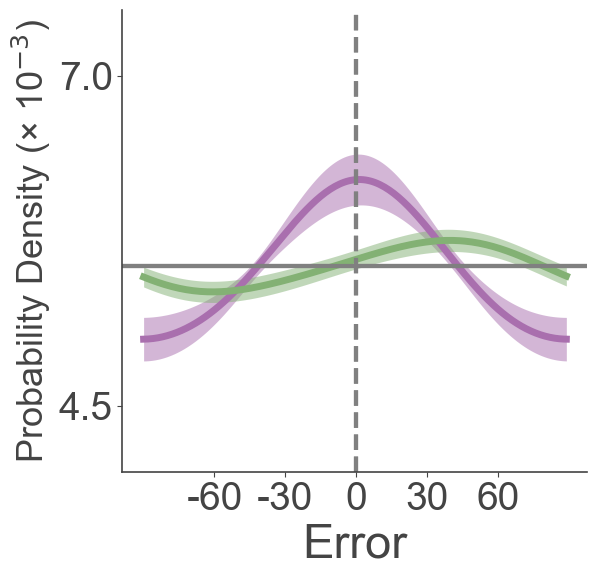

In [126]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
}

default_item_weights_lmb = lambda df: np.array([
    np.ones(len(df))/2,
    np.ones(len(df))/2,
]).T

stats_results = display_stats_and_distrib(ax,
    enc1_decode_results_after_cue_within_subj,
    stats_type='accuracy', 
    common_lmb=valid_isi_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=default_item_weights_lmb, # assuming taking all?
    sharpness=ISI_best_sharpness
)
print_stats_results_as_tables(stats_results)

plot_path = os.path.join(PLOTS_FOLDER, 'within_subj_enc1_after_cue_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

--- accuracy ---
         mean    sem  t_stat   p_val  df
stim 1 -0.057  0.095 -0.5948  0.7221  35
stim 2  0.074  0.093  0.7969  0.2154  35
--- bias ---
         mean  sem (1e-3)  t_stat   p_val  df
stim 1 -0.040       0.052 -0.7728  0.7776  35
stim 2 -0.003       0.060 -0.0554  0.5219  35


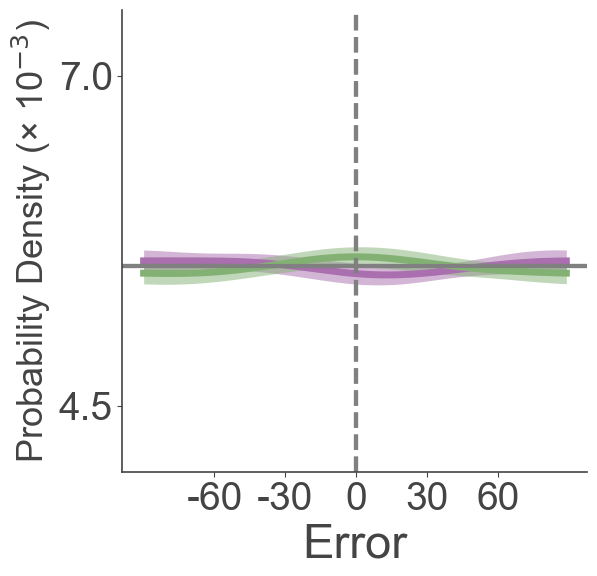

In [127]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
}

default_item_weights_lmb = lambda df: np.array([
    np.ones(len(df))/2,
    np.ones(len(df))/2,
]).T

stats_results = display_stats_and_distrib(ax,
    enc1_decode_results_during_cue_within_subj,
    stats_type='accuracy', 
    common_lmb=valid_isi_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=default_item_weights_lmb, # assuming taking all?
    sharpness=ISI_best_sharpness
)
print_stats_results_as_tables(stats_results)

plot_path = os.path.join(PLOTS_FOLDER, 'within_subj_enc1_during_cue_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

--- accuracy ---
         mean    sem  t_stat   p_val  df
stim 1 -0.048  0.089 -0.5460  0.7058  35
stim 2 -0.016  0.086 -0.1856  0.5731  35
--- bias ---
         mean  sem (1e-3)  t_stat   p_val  df
stim 1  0.087       0.048  1.8127  0.0392  35
stim 2  0.023       0.062  0.3682  0.3575  35


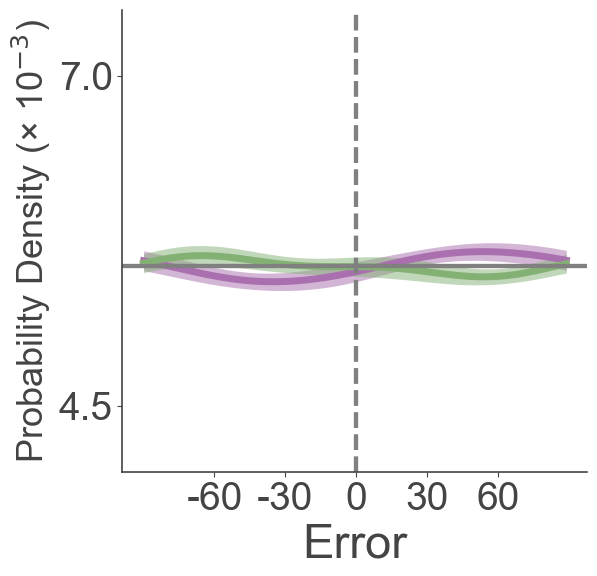

In [128]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
}

default_item_weights_lmb = lambda df: np.array([
    np.ones(len(df))/2,
    np.ones(len(df))/2,
]).T

stats_results = display_stats_and_distrib(ax,
    enc1_decode_results_before_cue_within_subj,
    stats_type='accuracy', 
    common_lmb=valid_isi_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=default_item_weights_lmb, # assuming taking all?
    sharpness=ISI_best_sharpness
)
print_stats_results_as_tables(stats_results)

plot_path = os.path.join(PLOTS_FOLDER, 'within_subj_enc1_before_cue_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

In [129]:
stat_extract_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
}

for stats_type in ['accuracy', 'sd', 'sur']:
    print(f'Saving {mode} {stats_type} stats')
    common_lmb = valid_isi_lmb
    if stats_type == 'sd':
        common_lmb = lambda d: valid_isi_lmb(d) & has_valid_prev_lmb(d)
    store_subject_stats(
        enc1_decode_results_after_cue_within_subj, 
        common_lmb, 
        stat_extract_settings, 
        stats_type, 
        f'within_subj_enc1_after_cue_combined',
        item_weights_lmb=isi_item_weights_lmb,
        sharpness=ISI_best_sharpness)

Saving click accuracy stats
Saving click sd stats
Saving click sur stats


##### now do within-subject analysis during ISI

In [130]:
isi_decode_results_within_subj = cv_train_test_within_subject_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    ISI_phase, ISI_phase, 
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, valid_isi_lmb,
    isi_item_weights_lmb, kfold=5)

--- accuracy ---
         mean    sem  t_stat   p_val    df  w_stat     n
stim 1  0.991  0.196  5.0557  0.0000  35.0     NaN   NaN
stim 2 -0.027  0.076     NaN  0.3811   NaN   353.0  36.0
--- bias ---
         mean  sem (1e-3)  t_stat   p_val  df
stim 1  0.053       0.042  1.2746  0.1054  35
stim 2 -0.046       0.053 -0.8536  0.8004  35


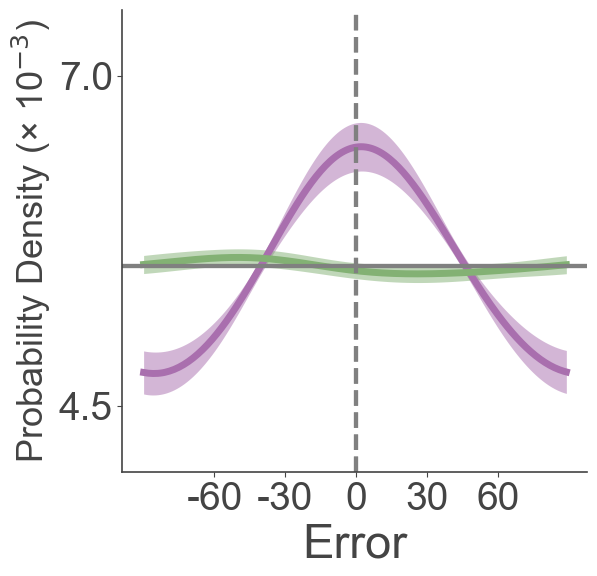

In [131]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
}

default_item_weights_lmb = lambda df: np.array([
    np.ones(len(df))/2,
    np.ones(len(df))/2,
]).T

stats_results = display_stats_and_distrib(ax,
    isi_decode_results_within_subj,
    stats_type='accuracy', 
    common_lmb=valid_isi_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=default_item_weights_lmb, # assuming taking all?
    sharpness=ISI_best_sharpness
)
print_stats_results_as_tables(stats_results)

plot_path = os.path.join(PLOTS_FOLDER, 'within_subj_isi_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

In [132]:
stat_extract_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'draw': {
        'target': 'stim 1',
        'lmb': draw_lmb,
    },
    'click': {
        'target': 'stim 1',
        'lmb': click_lmb,
    },
}

for stats_type in ['accuracy', 'sd', 'sur']:
    print(f'Saving {mode} {stats_type} stats')
    common_lmb = valid_isi_lmb
    if stats_type == 'sd':
        common_lmb = lambda d: valid_isi_lmb(d) & has_valid_prev_lmb(d)
    store_subject_stats(
        isi_decode_results_within_subj, 
        common_lmb, 
        stat_extract_settings, 
        stats_type, 
        f'within_subj_isi_combined',
        item_weights_lmb=isi_item_weights_lmb,
        sharpness=ISI_best_sharpness)

Saving click accuracy stats
Saving click sd stats
Saving click sur stats


##### Now repeat if for delay

In [133]:
delay_decode_results_within_subj = cv_train_test_within_subject_invert_encoding(
    DEFAULT_FORWARD_MODEL_PARAMS, 
    delay_phase, delay_phase, 
    ['stim_1', 'stim_2'], ['stim_1', 'stim_2'], 
    None, None,
    item_weights_lmb, kfold=5)

--- accuracy ---
           mean    sem  t_stat   p_val  df
stim 1    0.776  0.124  6.2370  0.0000  35
stim 2    0.409  0.129  3.1606  0.0016  35
combined  0.655  0.120  5.4534  0.0000  35
--- bias ---
           mean  sem (1e-3)  t_stat   p_val  df
stim 1   -0.048       0.051 -0.9398  0.8231  35
stim 2    0.059       0.073  0.8138  0.2106  35
combined -0.005       0.045 -0.1088  0.5430  35


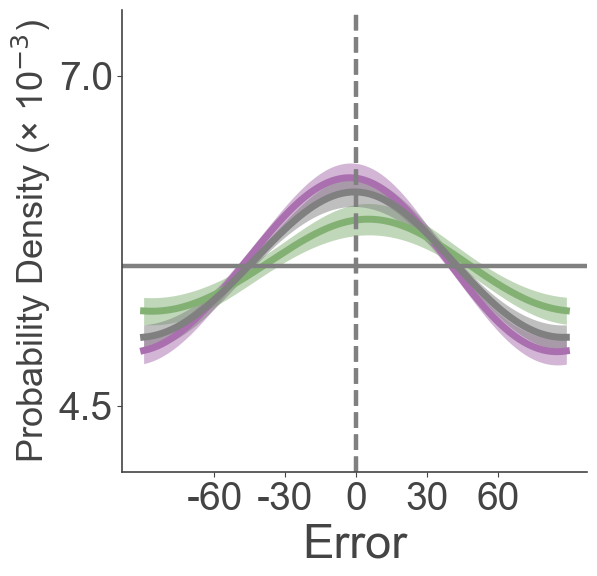

In [134]:
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
default_item_weights_lmb = lambda df: np.array([
    np.ones(len(df))/2,
    np.ones(len(df))/2,
]).T

stats_results = display_stats_and_distrib(ax,
    delay_decode_results_within_subj,
    stats_type='accuracy', 
    common_lmb=None, condition_lmbs=plot_settings,
    item_weights_lmb=default_item_weights_lmb, # assuming taking all?
    sharpness=ISI_best_sharpness
)
print_stats_results_as_tables(stats_results)

plot_path = os.path.join(PLOTS_FOLDER, 'within_subj_delay_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

In [135]:
stat_extract_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
    'draw': {
        'target': 'combined',
        'lmb': draw_lmb,
    },
    'click': {
        'target': 'combined',
        'lmb': click_lmb,
    },
}

for stats_type in ['accuracy', 'sd', 'sur']:
    print(f'Saving {mode} {stats_type} stats')
    common_lmb = None
    if stats_type == 'sd':
        common_lmb = has_valid_prev_lmb
    store_subject_stats(
        delay_decode_results_within_subj, 
        common_lmb, 
        stat_extract_settings, 
        stats_type, 
        f'within_subj_delay_combined',
        item_weights_lmb=item_weights_lmb,
        sharpness=delay_best_sharpness)

Saving click accuracy stats
Saving click sd stats
Saving click sur stats


##### Again, check whether encoding pattern generalize in within subject condition

In [136]:
enc1_isi_decode_results_within_subj = cv_train_test_within_subject_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    enc1_phase_after_cue, ISI_phase,
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, valid_isi_lmb,
    isi_item_weights_lmb, kfold=5)

--- accuracy ---
         mean    sem  w_stat   p_val     n  t_stat    df
stim 1  0.740  0.134   625.0  0.0000  36.0     NaN   NaN
stim 2 -0.043  0.082     NaN  0.6975   NaN -0.5219  35.0
--- bias ---
         mean  sem (1e-3)  t_stat   p_val  df
stim 1 -0.056       0.081 -0.6942  0.7539  35
stim 2  0.019       0.050  0.3849  0.3513  35


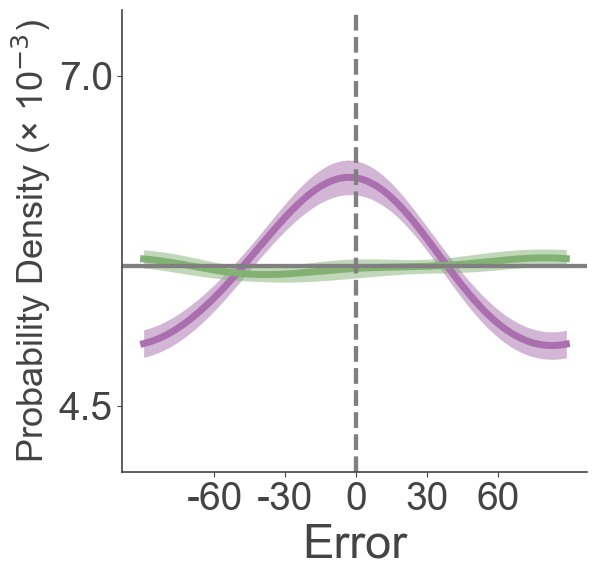

In [137]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
}

default_item_weights_lmb = lambda df: np.array([
    np.ones(len(df))/2,
    np.ones(len(df))/2,
]).T

stats_results = display_stats_and_distrib(ax,
    enc1_isi_decode_results_within_subj,
    stats_type='accuracy', 
    common_lmb=valid_isi_lmb, condition_lmbs=plot_settings,
    item_weights_lmb=default_item_weights_lmb, # assuming taking all?
    sharpness=ISI_best_sharpness
)
print_stats_results_as_tables(stats_results)

plot_path = os.path.join(PLOTS_FOLDER, 'within_subj_enc1_isi_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

In [138]:
enc1_delay_decode_results_within_subj = cv_train_test_within_subject_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    enc1_phase_after_cue, delay_phase, 
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, None,
    isi_item_weights_lmb, kfold=5)

--- accuracy ---
           mean    sem  t_stat   p_val    df  w_stat     n
stim 1    0.360  0.117  3.0821  0.0020  35.0     NaN   NaN
stim 2    0.335  0.107     NaN  0.0017   NaN   515.0  36.0
combined  0.338  0.098  3.4585  0.0007  35.0     NaN   NaN
--- bias ---
           mean  sem (1e-3)  t_stat   p_val  df
stim 1   -0.081       0.083 -0.9851  0.8343  35
stim 2   -0.032       0.061 -0.5246  0.6984  35
combined -0.044       0.045 -0.9736  0.8315  35


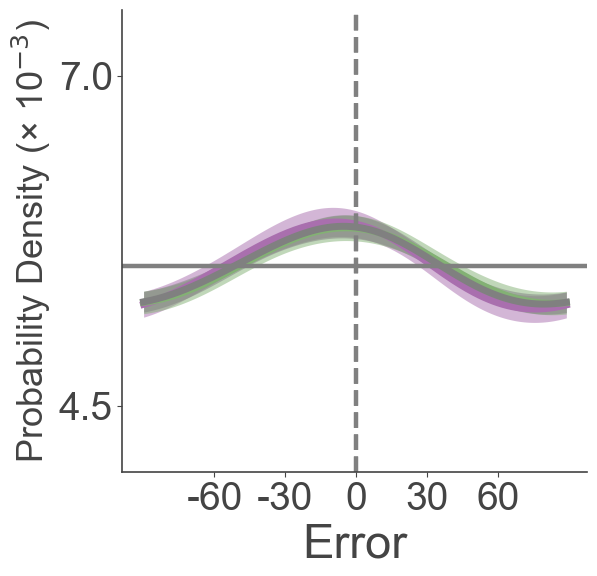

In [139]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

stats_results = display_stats_and_distrib(ax,
    enc1_delay_decode_results_within_subj,
    stats_type='accuracy', 
    common_lmb=None, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb, # assuming taking all?
    sharpness=delay_best_sharpness
)
print_stats_results_as_tables(stats_results)

plot_path = os.path.join(PLOTS_FOLDER, 'within_subj_enc1_delay_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

In [140]:
isi_delay_decode_results_within_subj = cv_train_test_within_subject_invert_encoding(
    DEFAULT_ISI_FORWARD_MODEL_PARAMS, 
    ISI_phase, delay_phase, 
    ['stim_1', ], ['stim_1', 'stim_2'], 
    valid_isi_lmb, None,
    isi_item_weights_lmb, kfold=5)

--- accuracy ---
           mean    sem  t_stat   p_val    df  w_stat     n
stim 1    0.687  0.142  4.8361  0.0000  35.0     NaN   NaN
stim 2    0.533  0.136  3.9278  0.0002  35.0     NaN   NaN
combined  0.591  0.126     NaN  0.0000   NaN   593.0  36.0
--- bias ---
           mean  sem (1e-3)  t_stat   p_val    df  w_stat     n
stim 1    0.161       0.050  3.2136  0.0014  35.0     NaN   NaN
stim 2    0.066       0.064  1.0280  0.1555  35.0     NaN   NaN
combined  0.089       0.048     NaN  0.0125   NaN   475.0  36.0


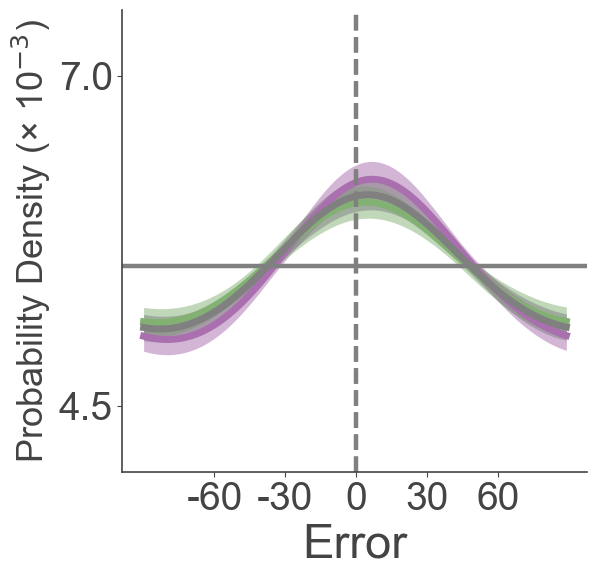

In [141]:
fig, ax = plt.subplots(1, figsize=(DEF_PLOT_W, DEF_PLOT_H))
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_valid_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_valid_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

stats_results = display_stats_and_distrib(ax,
    isi_delay_decode_results_within_subj,
    stats_type='accuracy', 
    common_lmb=None, condition_lmbs=plot_settings,
    item_weights_lmb=item_weights_lmb, # assuming taking all?
    sharpness=delay_best_sharpness
)
print_stats_results_as_tables(stats_results)
plot_path = os.path.join(PLOTS_FOLDER, 'within_subj_isi_delay_decoded_acc.png')
plt.savefig(plot_path, bbox_inches='tight')

#### Comments
- clicking is easier to decode; drawing seems more complex
- the distribution of erros is not perfectly centered at 0
- No clear traces of serial bias
- The transformation from channel activation prediction to stimuli seems trivial but is actually crucial but I haven't figured out a perfect solution...


## Now further split the delay

In [142]:
from utils.inverted_encoding import raw_within_across_phase_train_test

def within_across_phase_train_test(phases, train_test_lmb, 
        all_phase_steps=[0, 1], train_weight_lmb=item_weights_lmb):
    return raw_within_across_phase_train_test(
        phases, train_test_lmb, 
        subjs=all_subjs,
        train_test_iterator=across_subj_cross_phase_iterator,
        model_params=DEFAULT_FORWARD_MODEL_PARAMS,
        item_weights_lmb=train_weight_lmb,
        all_phase_steps=all_phase_steps,
    )

### First check something simpler?

In [143]:
critical_stim1_phases = [enc1_phase_after_cue, ISI_phase,]
within_stim1_only_phase_results = within_across_phase_train_test(
    critical_stim1_phases, stim1_valid_lmb, 
    all_phase_steps=[0,],
    train_weight_lmb=isi_item_weights_lmb)[0]

within_delay_phase_results = within_across_phase_train_test(
    delay_phases, None, all_phase_steps=[0,],
    train_weight_lmb=item_weights_lmb)[0]

100%|██████████| 9/9 [00:51<00:00,  5.70s/it]


In [183]:
within_all_phase_results = within_stim1_only_phase_results + within_delay_phase_results

In [207]:
cond_map = {
    'wheel': 'click',
}

def extract_critical_phase_stats(test_results, stat_type, n_stim1_only=2, mode_separate_train=False):
    # first two phases -- stim1- remembered only
    # last two phases -- stim1 or stim 2

    common_lmb = None
    if stat_type == 'sd':
        common_lmb = has_valid_prev_lmb

    collected_stats = []
    stats_settings = {
        'stim 1': {
            'target': 'stim 1',
            'lmb': stim1_valid_lmb,
            'to_plot': False,
        },
    }
    
    for t, time_point_results in enumerate(test_results):
        if t < n_stim1_only:
            target_name = 'stim 1'
            selected_item_weights_lmb = isi_item_weights_lmb
        else:
            target_name = 'combined'
            stats_settings = {
                'stim 1': {
                    'target': 'stim 1',
                    'lmb': stim1_valid_lmb,
                    'to_plot': False,
                },
                'stim 2': {
                    'target': 'stim 2',
                    'lmb': stim2_valid_lmb,
                    'to_plot': False,
                },
                'combined': {
                    'target': 'combined',
                    'lmb': None,
                    'to_plot': False,
                },
            }
            selected_item_weights_lmb = item_weights_lmb

        timepoint_stats = {}
        if mode_separate_train:
            for mode in ['draw', 'wheel']:
                mode_stats_settings = stats_settings.copy()
                mode_lmb = draw_lmb if mode == 'draw' else click_lmb
                mode_stats_settings[mode] = {
                    'target': target_name,
                    'lmb': mode_lmb,
                    'to_plot': False,
                }
                _, mode_stats_results = display_stats_and_distrib(
                    None,
                    time_point_results[cond_map.get(mode, mode)],
                    stats_type=stat_type, 
                    common_lmb=common_lmb, 
                    condition_lmbs=mode_stats_settings,
                    item_weights_lmb=selected_item_weights_lmb,
                    return_subj_stats=True)
                timepoint_stats[mode] = mode_stats_results[mode]

        else:
            stats_settings['draw'] = {
                'target': target_name,
                'lmb': draw_lmb,
                'to_plot': False,
            }
            stats_settings['wheel'] = {
                'target': target_name,
                'lmb': click_lmb,
                'to_plot': False,
            }

            _, raw_timepoint_stats = display_stats_and_distrib(
                None,
                time_point_results,
                stats_type=stat_type, 
                common_lmb=common_lmb, 
                condition_lmbs=stats_settings,
                item_weights_lmb=selected_item_weights_lmb,
                return_subj_stats=True)

            # select only relevant
            timepoint_stats = {
                'combined': raw_timepoint_stats[target_name],
                'draw': raw_timepoint_stats['draw'],
                'wheel': raw_timepoint_stats['wheel'],
            }

        collected_stats.append(timepoint_stats)

    return collected_stats


In [185]:
critical_acc_stats = extract_critical_phase_stats(
    within_all_phase_results, stat_type='accuracy')

In [ ]:
from utils.inverted_encoding import plot_critical_phase_mode_difference

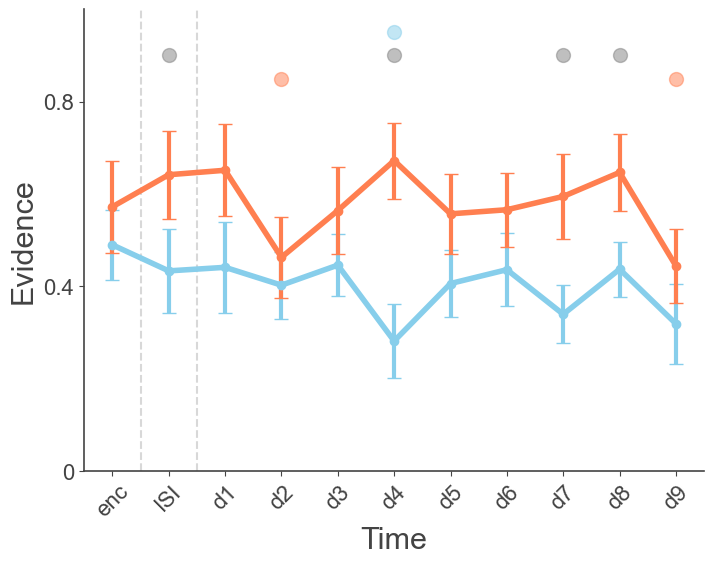

In [220]:
plot_critical_phase_mode_difference(
    time_stats=critical_acc_stats, stat_type='accuracy',
    mode_colors=MODE_COLOR_MAPPINGS, cond_color_map=cond_map,
    show_sig_change=True, sig_ref_first=False)

##### separate train-test for different modes?

In [221]:
raw_critical_mode_iem_results = {}
for mode in ['draw', 'click']:
    mode_lmb = mode_lmbs[mode]
    mode_stim1_lmb = lambda df: (stim1_valid_lmb(df) & mode_lmb(df))
    mode_within_stim1_only_phase_results = within_across_phase_train_test(
        critical_stim1_phases, mode_stim1_lmb, 
        all_phase_steps=[0,],
        train_weight_lmb=isi_item_weights_lmb)[0]

    mode_within_delay_phase_results = within_across_phase_train_test(
        delay_phases, mode_lmb, all_phase_steps=[0,],
        train_weight_lmb=item_weights_lmb)[0]

    raw_critical_mode_iem_results[mode] = mode_within_stim1_only_phase_results + \
        mode_within_delay_phase_results
    
critical_mode_iem_results = []
for draw_r, click_r in zip(
        raw_critical_mode_iem_results['draw'], 
        raw_critical_mode_iem_results['click']):
    combined_r = {
        'draw': draw_r,
        'click': click_r
    }
    critical_mode_iem_results.append(combined_r)
    

100%|██████████| 9/9 [00:21<00:00,  2.42s/it]


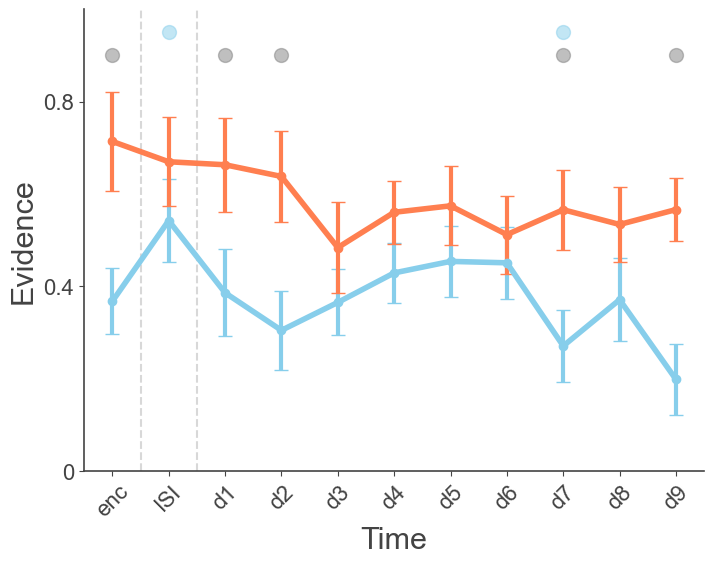

In [222]:
critical_mode_separate_stats = extract_critical_phase_stats(
    critical_mode_iem_results, stat_type='accuracy', 
    mode_separate_train=True)
plot_critical_phase_mode_difference(
    time_stats=critical_mode_separate_stats, stat_type='accuracy',
    mode_colors=MODE_COLOR_MAPPINGS, cond_color_map=cond_map,
    show_sig_change=True, sig_ref_first=False)

#### Now use one fixed phase for training, test on or subsequent phases

In [218]:
from utils.inverted_encoding import raw_ref_fixed_tested_all

def ref_fixed_tested_all(
        train_phase, test_phases, 
        train_stims, test_stims, 
        train_lmb, test_lmb, 
        train_weight_lmb,
        mode_separate_train):
    return raw_ref_fixed_tested_all(
        train_test_iterator=across_subj_cross_phase_iterator,
        model_params=DEFAULT_FORWARD_MODEL_PARAMS,
        train_phase=train_phase, test_phases=test_phases,
        train_stims=train_stims, test_stims=test_stims,
        train_lmb=train_lmb, test_lmb=test_lmb, 
        train_weight_lmb=train_weight_lmb,
        n_subjects=n_subjects,
        separate_mode=mode_separate_train
    )

all_critical_phase = critical_stim1_phases + delay_phases

def all_fixed_train_test_across_critical(stat_type, mode_separate_train=True):
    ref_ids = [0, 1, 2]
    ref_is_stim1_only = [True, True, False]

    # collect raw results
    for i, train_phase_id in enumerate(ref_ids):
        is_stim1_only = ref_is_stim1_only[i]
        train_stims = ['stim_1',] if is_stim1_only else ['stim_1', 'stim_2']
        train_lmb = stim1_valid_lmb if is_stim1_only else None
        train_weights = isi_item_weights_lmb if is_stim1_only else item_weights_lmb
        raw_iem_results = ref_fixed_tested_all(
            train_phase=all_critical_phase[train_phase_id], 
            test_phases=all_critical_phase[train_phase_id:], 
            train_stims=train_stims, 
            test_stims=['stim_1', 'stim_2'], 
            train_lmb=train_lmb, 
            test_lmb=None, 
            train_weight_lmb=train_weights,
            mode_separate_train=mode_separate_train
        )

        # collect stats
        n_stim1_only_test = int(np.sum(
            ref_is_stim1_only[i:]
        ))
        critical_stats = extract_critical_phase_stats(
            raw_iem_results, 
            stat_type=stat_type, 
            n_stim1_only=n_stim1_only_test,
            mode_separate_train=mode_separate_train
        )
        
        # plot it
        plot_critical_phase_mode_difference(
            time_stats=critical_stats, stat_type=stat_type,
            mode_colors=MODE_COLOR_MAPPINGS, cond_color_map=cond_map,
            n_stim1_only=n_stim1_only_test,
            show_sig_change=True,)


100%|██████████| 9/9 [00:43<00:00,  4.85s/it]


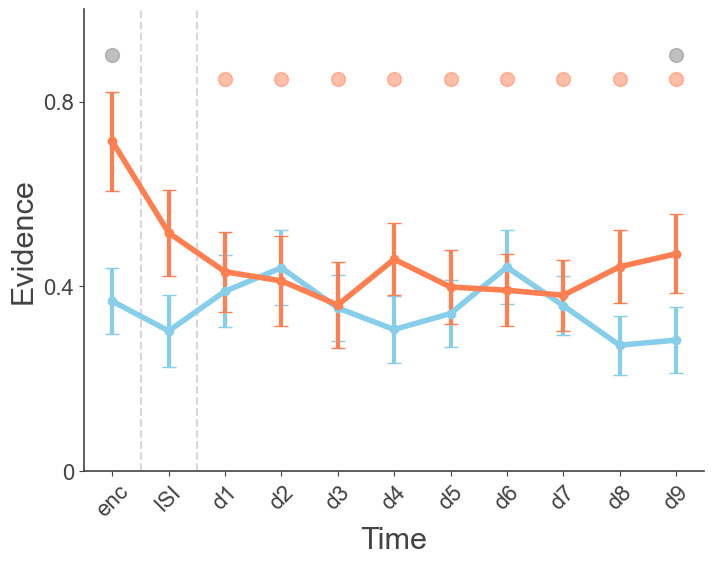

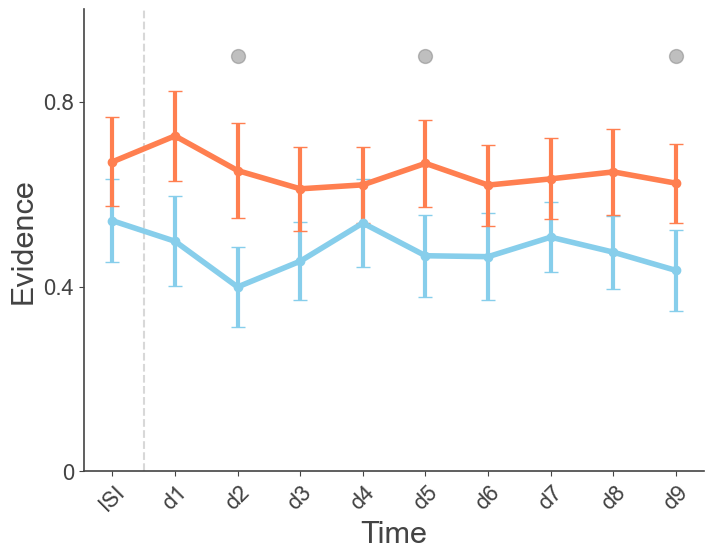

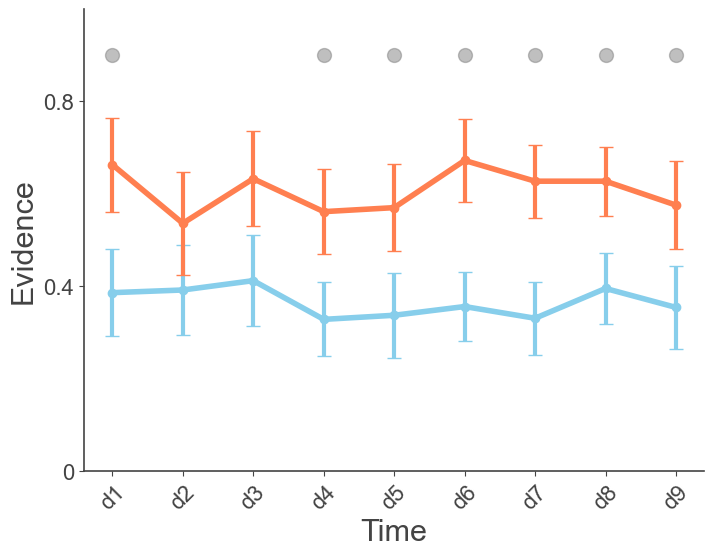

In [219]:
all_fixed_train_test_across_critical('accuracy', mode_separate_train=True)

### Then more complicated analysis

#### create sliding windows throughout the delay

In [ ]:
from utils.inverted_encoding import generate_windows

DELAY_WINDOWS = generate_windows(delay_phase, 20, 5)
N_DELAY_WINDOW = len(DELAY_WINDOWS)
print(f'{N_DELAY_WINDOW} windows, each of {len(DELAY_WINDOWS[0])} time points')

15 windows, each of 20 time points


#### Load subjects of general good decodability

In [ ]:
subj_delay_quality_path = os.path.join(
    PROCESSED_FOLDER, 'whole_delay_combined', 'accuracy.json')
with open(subj_delay_quality_path, 'r') as fp:
    subj_delay_quality = json.load(fp)

In [ ]:
good_acc_thresh = 0.4
good_delay_subjects = [int(subj) for subj, acc in subj_delay_quality['combined']['accuracy'].items() if acc > good_acc_thresh]

In [ ]:
len(good_delay_subjects)

25

In [ ]:
good_delay_subject_set = set(good_delay_subjects)
good_delay_subject_lmb = lambda d: d['participant'].isin(good_delay_subject_set).values

### distribution of errors

In [ ]:
from utils.inverted_encoding import (
    raw_plot_single_stats_over_phase,
    raw_plot_stats_over_phase
)

def plot_single_stats_over_phase(
        ax, pred_results, stats_type, stat_name, phase_step,
        plot_settings, common_lmb, 
        plot_ymin=None, plot_ymax=None, label=None,
        show_significance=False):

    return raw_plot_single_stats_over_phase(
        ax, pred_results, stats_type, stat_name, phase_step,
        plot_settings, common_lmb, 
        plot_ymin=plot_ymin, plot_ymax=plot_ymax, label=label,
        stats_computation_func=display_stats_and_distrib,
        item_weights_lmb=item_weights_lmb,
        show_significance=show_significance)

def plot_stats_over_phase(
        pred_results, stats_type, plot_settings, 
        common_lmb, plot_ymin=None, plot_ymax=None,
        show_single_significance=False,
        show_pairwise_significance=False):
    return raw_plot_stats_over_phase(
        pred_results, stats_type, plot_settings,
        common_lmb, plot_ymin=plot_ymin, plot_ymax=plot_ymax,
        stats_computation_func=display_stats_and_distrib,
        item_weights_lmb=item_weights_lmb,
        show_single_significance=show_single_significance,
        show_pairwise_significance=show_pairwise_significance,
    )

#### First check when memory load = 2

In [ ]:
mem2_cross_phase_results = within_across_phase_train_test(DELAY_WINDOWS, valid_both_lmb)

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [01:54<00:00,  7.61s/it]


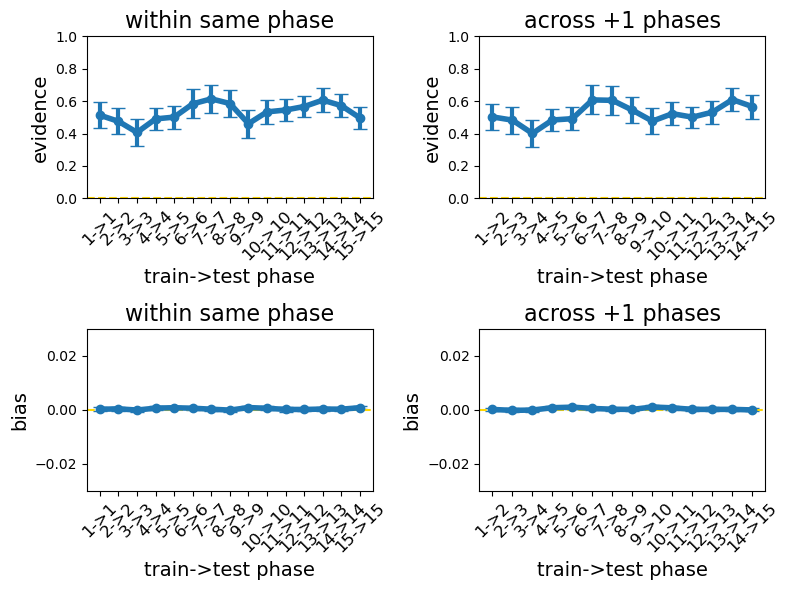

In [ ]:
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

plot_stats_over_phase(
    mem2_cross_phase_results, 'accuracy', 
    plot_settings, valid_both_lmb,
    show_single_significance=False)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_multi_phases_acc_stats.png')
plt.savefig(plot_path, bbox_inches='tight')

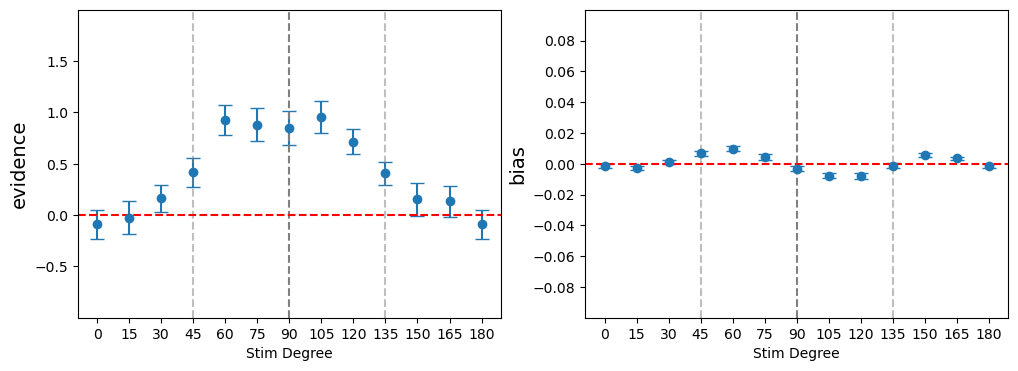

In [ ]:
display_acc_bias_as_tuning(
    results=mem2_cross_phase_results[0][-1],
    common_lmb=valid_both_lmb, condition_name='last_phase_delay')

#### TODO: compute all stats

#### for all, draw, and click

In [ ]:
for phase_id in [0, -1]:
    phase_name = 'first' if phase_id == 0 else 'last'
    print("phase: ", phase_name)
    test_lmb = valid_both_lmb
    stat_extract_settings = {
        'stim 1': {
            'target': 'stim 1',
            'lmb': stim1_valid_lmb,
        },
        'stim 2': {
            'target': 'stim 2',
            'lmb': stim2_valid_lmb,
        },
        'combined': {
            'target': 'combined',
            'lmb': None,
        },
        'draw': {
            'target': 'combined',
            'lmb': draw_lmb,
        },
        'click': {
            'target': 'combined',
            'lmb': click_lmb,
        }
    }

    results = mem2_cross_phase_results[0][phase_id]
    for stats_type in ['accuracy', 'sd', 'sur']:
        print(f'Saving {stats_type} stats')
        common_lmb = test_lmb
        if stats_type == 'sd':
            common_lmb = has_valid_prev_lmb
        store_subject_stats(
            results, 
            common_lmb, 
            stat_extract_settings, 
            stats_type, 
            f'delay_{phase_name}_phase_combined',
            item_weights_lmb=item_weights_lmb,
            sharpness=delay_best_sharpness)
        

phase:  first
Saving accuracy stats
Saving sd stats
Saving sur stats
phase:  last
Saving accuracy stats
Saving sd stats
Saving sur stats


##### Comment:

Probably it is **NOT** possible to tease out surrounding bias...Anyway the decoding of the current target will be interfered by the non-target; but we can check how the bias change over time?

#### Further split the draw and click

##### Drawing

In [ ]:
draw_both_lmb = lambda df: (draw_lmb(df) & valid_both_lmb(df))

In [ ]:
draw_mem2_cross_phase_results = within_across_phase_train_test(
    DELAY_WINDOWS, draw_both_lmb)

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [01:17<00:00,  5.16s/it]


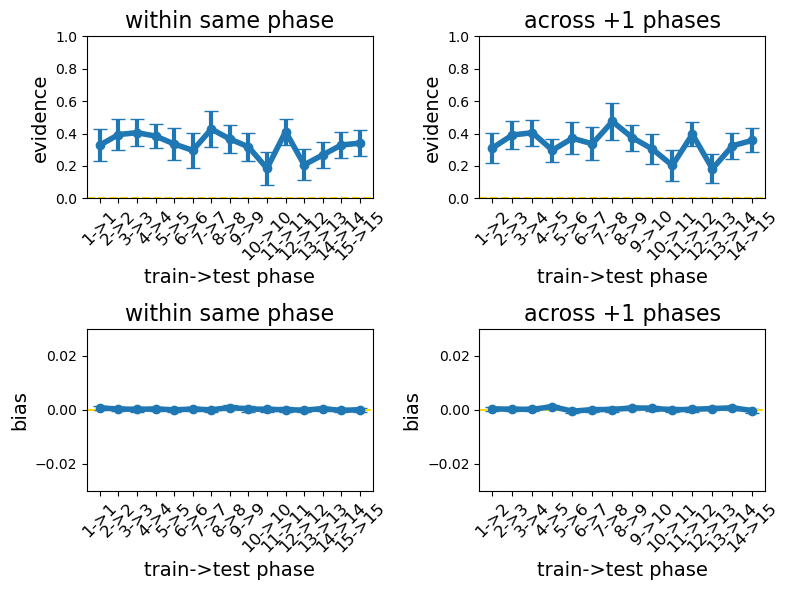

In [ ]:
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

plot_stats_over_phase(
    draw_mem2_cross_phase_results, 'accuracy', 
    plot_settings, draw_both_lmb)
plot_path = os.path.join(PLOTS_FOLDER, 'draw_delay_decoded_multi_phases_acc_stats.png')
plt.savefig(plot_path, bbox_inches='tight')

##### are there oblique or cardinal bias the last phase ?

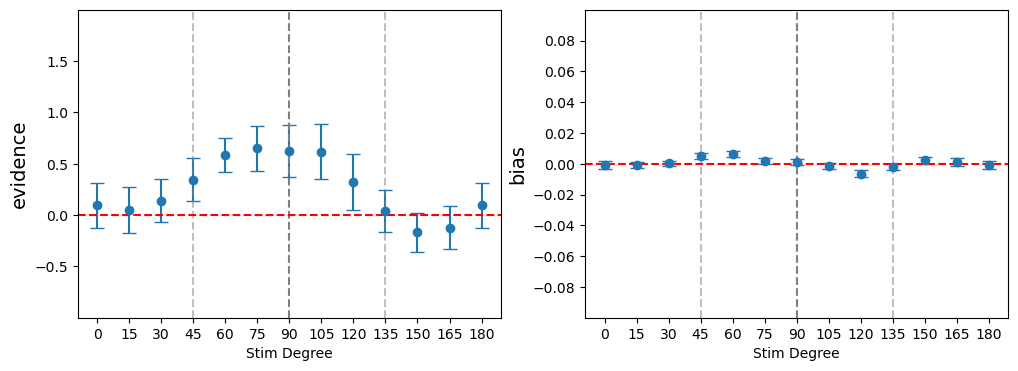

In [ ]:
display_acc_bias_as_tuning(
    results=draw_mem2_cross_phase_results[0][0],
    common_lmb=draw_both_lmb, condition_name='draw_first_phase_delay')

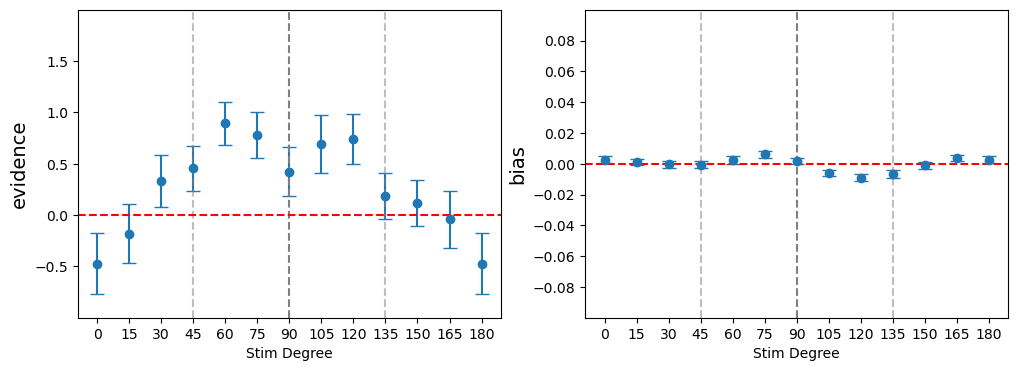

In [ ]:
display_acc_bias_as_tuning(
    results=draw_mem2_cross_phase_results[0][-1],
    common_lmb=draw_both_lmb, condition_name='draw_last_phase_delay')

##### Clicking

In [ ]:
click_both_lmb = lambda df: (click_lmb(df) & valid_both_lmb(df))

In [ ]:
click_mem2_cross_phase_results = within_across_phase_train_test(
    DELAY_WINDOWS, click_both_lmb)

100%|██████████| 15/15 [01:16<00:00,  5.11s/it]


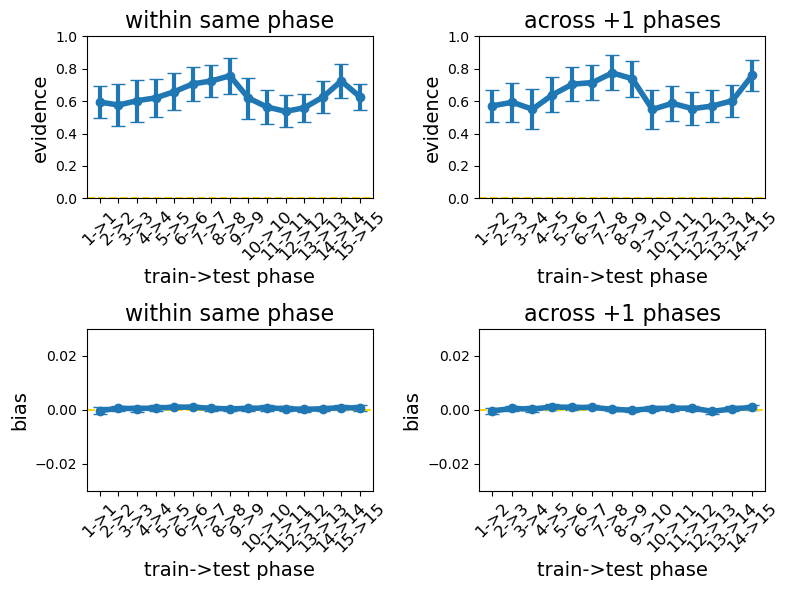

In [ ]:
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

plot_stats_over_phase(
    click_mem2_cross_phase_results, 'accuracy', 
    plot_settings, click_both_lmb)
plot_path = os.path.join(PLOTS_FOLDER, 'click_delay_decoded_multi_phases_acc_stats.png')
plt.savefig(plot_path, bbox_inches='tight')

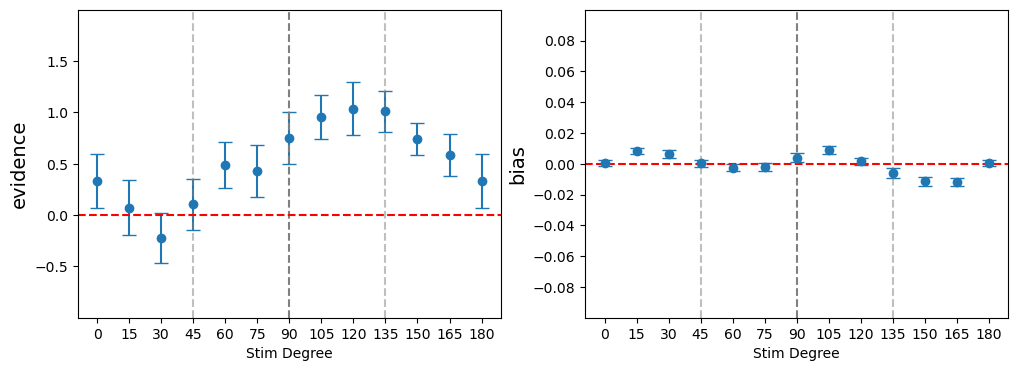

In [ ]:
display_acc_bias_as_tuning(
    results=click_mem2_cross_phase_results[0][0],
    common_lmb=click_both_lmb, condition_name='click_first_phase_delay')

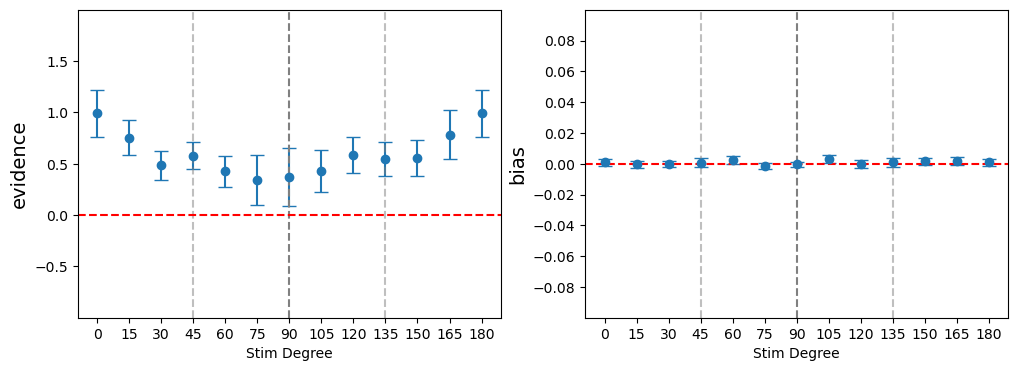

In [ ]:
display_acc_bias_as_tuning(
    results=click_mem2_cross_phase_results[0][-1],
    common_lmb=click_both_lmb, condition_name='click_last_phase_delay')

##### Also store the stats at the first and last phase of delay

In [ ]:
mode_cross_phase_results = {
    'draw': draw_mem2_cross_phase_results,
    'click': click_mem2_cross_phase_results,
}

for phase_id in [0, -1]:
    phase_name = 'first' if phase_id == 0 else 'last'
    for mode in ['draw', 'click']:
        test_lmb = mode_lmbs[mode]
        stat_extract_settings = {
            'stim 1': {
                'target': 'stim 1',
                'lmb': stim1_valid_lmb,
            },
            'stim 2': {
                'target': 'stim 2',
                'lmb': stim2_valid_lmb,
            },
            'combined': {
                'target': 'combined',
                'lmb': None,
            },
        }

        results = mode_cross_phase_results[mode][0][phase_id]

        for stats_type in ['accuracy', 'sd', 'sur']:
            print(f'Saving {mode} {stats_type} stats')
            common_lmb = test_lmb
            if stats_type == 'sd':
                common_lmb = mode_prev_lmbs[mode]
            store_subject_stats(
                results, 
                common_lmb, 
                stat_extract_settings, 
                stats_type, 
                f'delay_{phase_name}_phase_{mode}2{mode}',
                item_weights_lmb=item_weights_lmb,
                sharpness=delay_best_sharpness)
        

Saving draw accuracy stats
Saving draw sd stats
Saving draw sur stats
Saving click accuracy stats
Saving click sd stats
Saving click sur stats
Saving draw accuracy stats
Saving draw sd stats
Saving draw sur stats
Saving click accuracy stats
Saving click sd stats
Saving click sur stats


In [ ]:
for phase_id in [0, -1]:
    phase_name = 'first' if phase_id == 0 else 'last'
    test_lmb = valid_both_lmb
    stat_extract_settings = {
        'stim 1': {
            'target': 'stim 1',
            'lmb': stim1_valid_lmb,
        },
        'stim 2': {
            'target': 'stim 2',
            'lmb': stim2_valid_lmb,
        },
        'combined': {
            'target': 'combined',
            'lmb': None,
        },
    }

    results = mem2_cross_phase_results[0][phase_id]
    for stats_type in ['accuracy', 'sd', 'sur']:
        print(f'Saving {mode} {stats_type} stats')
        common_lmb = test_lmb
        if stats_type == 'sd':
            common_lmb = mode_prev_lmbs[mode]
        store_subject_stats(
            results, 
            common_lmb, 
            stat_extract_settings, 
            stats_type, 
            f'delay_{phase_name}_phase_combined',
            item_weights_lmb=item_weights_lmb,
            sharpness=delay_best_sharpness)
        

Saving click accuracy stats
Saving click sd stats
Saving click sur stats
Saving click accuracy stats
Saving click sd stats
Saving click sur stats


#### When does draw and click start diverging?

In [ ]:
from tqdm import tqdm

def within_phase_cross_mode_train_test(phases, train_lmb, test_lmb):
    all_phase_steps = [0,]
    n_train_phases = len(phases)
    phases_results = [[] for _ in all_phase_steps]

    n_subjects = len(all_subjs)
    for train_id in tqdm(range(n_train_phases)):
        for phase_step in all_phase_steps:
            test_id = train_id + phase_step
            if test_id >= len(phases):
                continue
            # get results
            train_phase = phases[train_id]
            test_phase = phases[test_id]
            results = cv_train_test_invert_encoding(
                DEFAULT_FORWARD_MODEL_PARAMS, 
                train_phase, test_phase, 
                ['stim_1', 'stim_2'], ['stim_1', 'stim_2'], 
                train_lmb, test_lmb, 
                item_weights_lmb, n_subjects, use_tqdm=False)
            phases_results[phase_step].append(results)

    return phases_results

In [ ]:
within_phase_draw2click_results = within_phase_cross_mode_train_test(
    DELAY_WINDOWS, draw_both_lmb, click_both_lmb)

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


In [ ]:
within_phase_click2draw_results = within_phase_cross_mode_train_test(
    DELAY_WINDOWS, click_both_lmb, draw_both_lmb)

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:39<00:00,  2.61s/it]


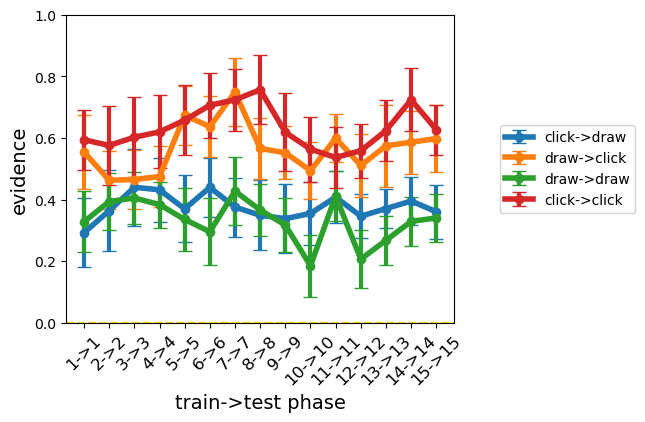

In [ ]:
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

fig, ax = plt.subplots(1, figsize=(5, 4))
plot_single_stats_over_phase(
    ax, within_phase_click2draw_results[0], 
    'accuracy', 'accuracy', 0,
    plot_settings, draw_both_lmb, 
    plot_ymin=None, plot_ymax=None, label='click->draw')
plot_single_stats_over_phase(
    ax, within_phase_draw2click_results[0], 
    'accuracy', 'accuracy', 0,
    plot_settings, click_both_lmb, 
    plot_ymin=None, plot_ymax=None, label='draw->click')

# for comparision, plot the within mode results
plot_single_stats_over_phase(
    ax, draw_mem2_cross_phase_results[0],
    'accuracy', 'accuracy', 0,
    plot_settings, draw_both_lmb,
    plot_ymin=None, plot_ymax=None, label='draw->draw')
plot_single_stats_over_phase(
    ax, click_mem2_cross_phase_results[0],
    'accuracy', 'accuracy', 0,
    plot_settings, click_both_lmb,
    plot_ymin=None, plot_ymax=None, label='click->click')

plt.legend(bbox_to_anchor=(1.1, 0.5), loc='center left')
plot_path = os.path.join(PLOTS_FOLDER, 'cross_mode_delay_decoded_multi_phases_acc_stats.png')
plt.savefig(plot_path, bbox_inches='tight')


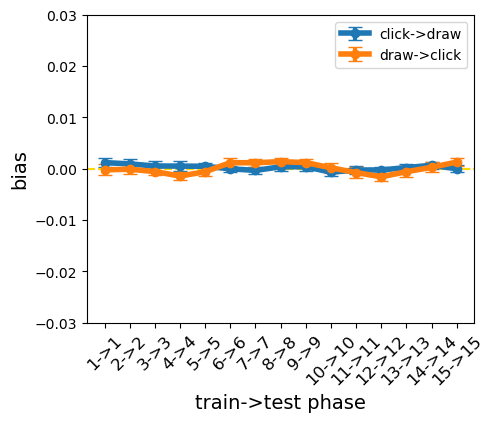

In [ ]:
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

fig, ax = plt.subplots(1, figsize=(5, 4))
plot_single_stats_over_phase(
    ax, within_phase_click2draw_results[0], 
    'accuracy', 'bias', 0,
    plot_settings, draw_both_lmb, 
    plot_ymin=None, plot_ymax=None, label='click->draw')
plot_single_stats_over_phase(
    ax, within_phase_draw2click_results[0], 
    'accuracy', 'bias', 0,
    plot_settings, click_both_lmb, 
    plot_ymin=None, plot_ymax=None, label='draw->click')

plt.legend(bbox_to_anchor=(1, 1), loc='upper right')
plot_path = os.path.join(PLOTS_FOLDER, 'cross_mode_delay_decoded_multi_phases_acc_bias_stats.png')
plt.savefig(plot_path, bbox_inches='tight')


##### Hypothesis: the gaze patterns 'evolve' over time, but differently for different modes

In [ ]:
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': None,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': None,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

# phase 1-> 6, 6 -> 11, 1 -> 11
def show_over_delay_decoding_divergence(common_lmb):
    start_id = 0
    end_id = len(DELAY_WINDOWS) - 1
    mid1_id = int(np.round(len(DELAY_WINDOWS) / 3)) - 1
    mid2_id = int(np.round(len(DELAY_WINDOWS) * 2 / 3)) - 1

    phase_ids = [start_id, mid1_id, mid2_id, end_id]
    collected_results = {
        'phase_ids': phase_ids,
    }
    for stat_name in ['accuracy', 'bias']:
        for stype in ['mean', 'sem']:
            collected_results[f'{stat_name}_{stype}'] = np.zeros((len(phase_ids), len(phase_ids)))
            collected_results[f'{stat_name}_{stype}'].fill(np.nan)

    for train_id, test_id in zip(
            [0, 1, 2, 0, 1, 0],
            [1, 2, 3, 2, 3, 3]):
        train_phase = DELAY_WINDOWS[phase_ids[train_id]]
        test_phase = DELAY_WINDOWS[phase_ids[test_id]]
        results = cv_train_test_invert_encoding(
            DEFAULT_FORWARD_MODEL_PARAMS, 
            train_phase, test_phase, 
            ['stim_1', 'stim_2'], ['stim_1', 'stim_2'], 
            common_lmb, common_lmb, 
            item_weights_lmb, n_subjects, use_tqdm=False)
        
        # compute accuracy
        stats = display_stats_and_distrib(
            None, results,
            stats_type='accuracy', 
            common_lmb=common_lmb, condition_lmbs=plot_settings,
            item_weights_lmb=item_weights_lmb)
        stats = stats['combined']
        print(f'==={train_id} -> {test_id}===')

        # formulate data
        for stat_name in ['accuracy', 'bias']:
            for stype in ['mean', 'sem']:
                collected_results[f'{stat_name}_{stype}'][train_id, test_id] = stats[stat_name][stype]

        print(f'accuracy: {stats["accuracy"]["mean"]:.3f} +/- {stats["accuracy"]["sem"]:.3f}')
        print(f'bias: {stats["bias"]["mean"]:.3f} +/- {stats["bias"]["sem"]:.3f}')

    return collected_results

def plot_cross_phase_evolve(ax, results, stat_name):
    phase_ids = results['phase_ids']
    mean_name = f'{stat_name}_mean'
    sem_name = f'{stat_name}_sem'
    mean_table = results[mean_name]
    sem_table = results[sem_name]

    color_level_maps = [
        'blue', 'green', 'red',]

    n_phases = len(mean_table) 
    for i in range(n_phases):
        for j in range(i+1, n_phases):
            if np.isnan(mean_table[i, j]):
                continue
            color = color_level_maps[j-i-1]
            ax.fill_between(
                [i, j], 
                mean_table[i, j] - sem_table[i, j], 
                mean_table[i, j] + sem_table[i, j], 
                alpha=0.2, color=color, linewidth=0)
            ax.plot(
                [i, j], [mean_table[i, j], mean_table[i, j]], 
                marker='o',
                color=color, linewidth=2)
            
    for i, phase_id in enumerate(phase_ids):
        ax.axvline(i, color='gray', linestyle='--', alpha=0.3)
    
    ax.set_xticks(np.arange(n_phases))
    ax.set_xticklabels(phase_ids)
    ax.set_xlabel('phases', fontsize=16)
    ylabel_name = 'generalizability' if stat_name == 'accuracy' else 'shift'
    ax.set_ylabel(ylabel_name, fontsize=16)


In [ ]:
draw_cross_phase_evolve = show_over_delay_decoding_divergence(draw_both_lmb)

===0 -> 1===
accuracy: 0.342 +/- 0.084
bias: 0.000 +/- 0.001
===1 -> 2===
accuracy: 0.516 +/- 0.100
bias: 0.001 +/- 0.001
===2 -> 3===
accuracy: 0.214 +/- 0.081
bias: 0.001 +/- 0.001
===0 -> 2===
accuracy: 0.387 +/- 0.085
bias: -0.000 +/- 0.001
===1 -> 3===
accuracy: 0.373 +/- 0.107
bias: 0.001 +/- 0.001
===0 -> 3===
accuracy: 0.380 +/- 0.085
bias: 0.000 +/- 0.001


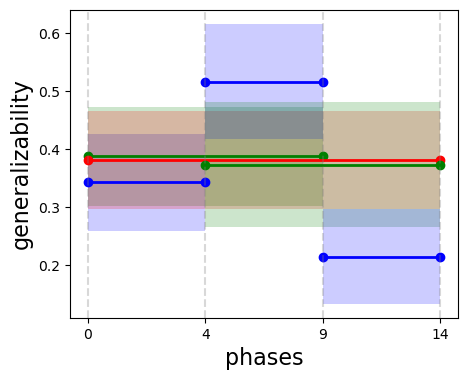

In [ ]:
fig, ax = plt.subplots(1, figsize=(5, 4))
plot_cross_phase_evolve(ax, draw_cross_phase_evolve, 'accuracy')
plot_path = os.path.join(PLOTS_FOLDER, 'draw_cross_phase_evolve.png')
plt.savefig(plot_path, bbox_inches='tight')

In [ ]:
click_cross_phase_evolve = show_over_delay_decoding_divergence(click_both_lmb)

===0 -> 1===
accuracy: 0.618 +/- 0.089
bias: 0.000 +/- 0.001
===1 -> 2===
accuracy: 0.684 +/- 0.119
bias: 0.001 +/- 0.001
===2 -> 3===
accuracy: 0.658 +/- 0.095
bias: 0.000 +/- 0.001
===0 -> 2===
accuracy: 0.592 +/- 0.099
bias: -0.001 +/- 0.001
===1 -> 3===
accuracy: 0.531 +/- 0.102
bias: 0.001 +/- 0.001
===0 -> 3===
accuracy: 0.680 +/- 0.103
bias: -0.000 +/- 0.001


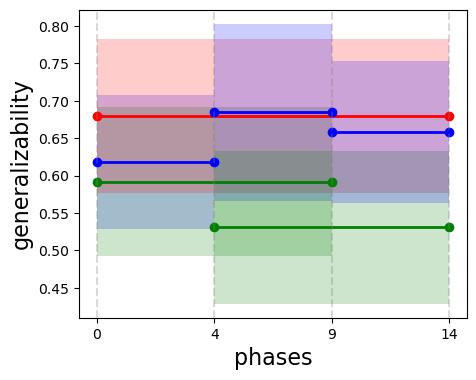

In [ ]:
fig, ax = plt.subplots(1, figsize=(5, 4))
plot_cross_phase_evolve(ax, click_cross_phase_evolve, 'accuracy')
plot_path = os.path.join(PLOTS_FOLDER, 'click_cross_phase_evolve.png')
plt.savefig(plot_path, bbox_inches='tight')

**comment**: ok hard to tell. But it seems for drawing there is a big shift in representation especially during the middle phase; in comparision, representation of clicking is more stable. This correspond to the self-reported strategy (from the prelimary study)

#### Lastly, switch to memory load is 1

In [ ]:
mem1_cross_phase_results = within_across_phase_train_test(
    DELAY_WINDOWS, valid_single_item_lmb)

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [01:07<00:00,  4.47s/it]


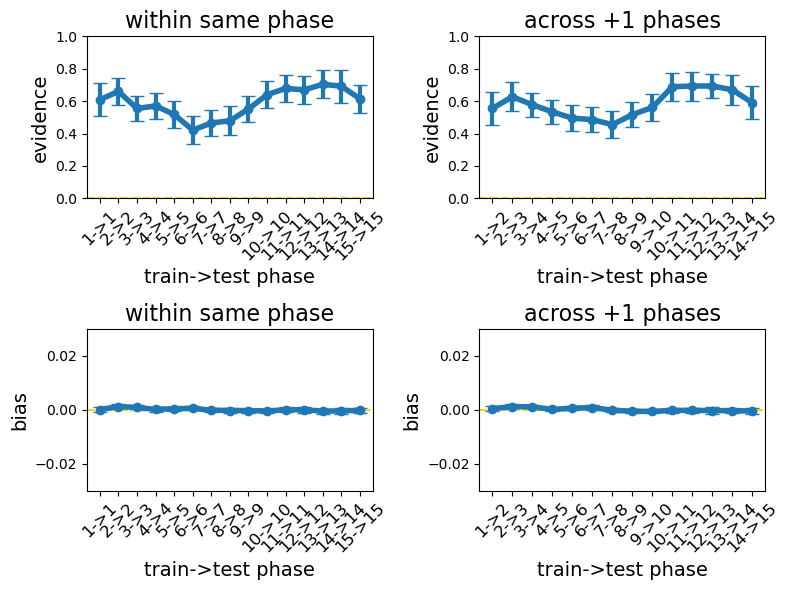

In [ ]:
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_only_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_only_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

plot_stats_over_phase(
    mem1_cross_phase_results, 'accuracy', 
    plot_settings, valid_single_item_lmb)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_single_phases_acc_stats.png')
plt.savefig(plot_path, bbox_inches='tight')

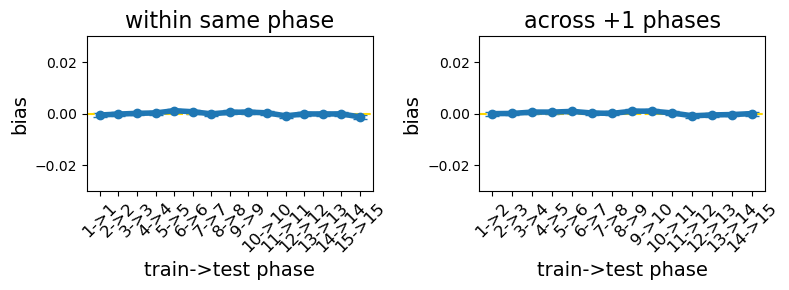

In [ ]:
plot_settings = {
    'stim 1': {
        'target': 'stim 1',
        'lmb': stim1_only_lmb,
    },
    'stim 2': {
        'target': 'stim 2',
        'lmb': stim2_only_lmb,
    },
    'combined': {
        'target': 'combined',
        'lmb': None,
    },
}

plot_stats_over_phase(
    mem1_cross_phase_results, 'sd', 
    plot_settings, single_has_prev_lmb)
plot_path = os.path.join(PLOTS_FOLDER, 'delay_decoded_single_phases_sd_stats.png')
plt.savefig(plot_path, bbox_inches='tight')

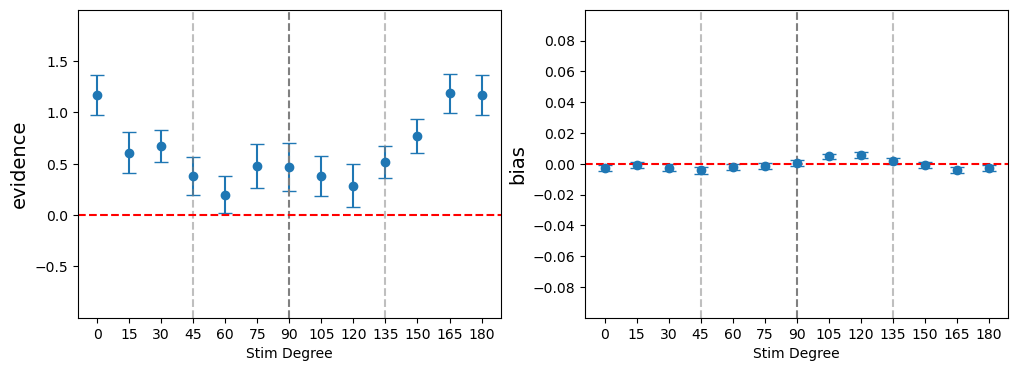

In [ ]:
display_acc_bias_as_tuning(
    results=mem1_cross_phase_results[0][-1],
    common_lmb=valid_single_item_lmb, condition_name='last_phase_single_delay')

##### Comment
But we can directly plot SURROUNDING bias for load=1. There is no significant bias though. Also there is no significant serial bias. All aligns with the behavior results.

#### Also store the decoded...

In [ ]:
def compute_and_store_decoded_distrib(all_results, result_name, sharpness=delay_best_sharpness, lmb=None):
    all_result_path = os.path.join(PROCESSED_FOLDER, 'predictions', f'{result_name}')
    os.makedirs(all_result_path, exist_ok=True)

    # store data apply to the whole phase
    y_df_path = os.path.join(all_result_path, 'y_df.csv')
    ys_path = os.path.join(all_result_path, 'ys.npy')

    for tid, results in enumerate(all_results):
        # process the result at time t
        result_path = os.path.join(all_result_path, f'phase_{tid}')
        os.makedirs(result_path, exist_ok=True)

        y_pred_distrib = channel_weights_to_pseudo_distrib(
            results['preds'], delay_model, sharpness=sharpness)
        y_df = results['test_df'].reset_index(drop=True)
        ys = results['test_ys']

        # note that df have been shuffled so we need to correct the order...
        trial_orders = y_df['TRIALID'].argsort()
        y_df = y_df.iloc[trial_orders].reset_index(drop=True)
        ys = ys[trial_orders]
        y_pred_distrib = y_pred_distrib[trial_orders]

        # lmb fitting
        if lmb is not None:
            y_mask = lmb(y_df)
            y_df = y_df[y_mask]
            ys = ys[y_mask]
            y_pred_distrib = y_pred_distrib[y_mask]

        # store the settings
        if tid == 0:
            y_df.to_csv(y_df_path, index=False)
            np.save(ys_path, ys)

        # store the raw predicted distribution
        y_pred_distrib_path = os.path.join(result_path, 'y_pred_distrib.npy')
        np.save(y_pred_distrib_path, y_pred_distrib)

        # store the aligned version
        aligned_path = os.path.join(result_path, 'aligned')
        os.makedirs(aligned_path, exist_ok=True)
        stim_names = ['stim_1', 'stim_2']
        for sid, stim_name in enumerate(stim_names):
            # specify the references to compare with
            stim_path = os.path.join(aligned_path, f'{stim_name}')
            os.makedirs(stim_path, exist_ok=True)
            ref_types = {
                'target': '',
                'nontarget': f'stim_{2-sid}',
                'previous': 'prev_last_response',
            }
            for ref_type in ref_types:
                ref_align_path = os.path.join(stim_path, f'{ref_type}.npy')
                ref_name = ref_types[ref_type]
                refs = None
                if ref_name:
                    refs = y_df[ref_name].to_numpy(copy=True)

                # save the aligned distribution and mask
                y_distrib, y_valid_mask = shift_align_distrib(
                    y_pred_distrib, ys[:, sid], refs=refs)
                y_distrib[~y_valid_mask] = np.nan
                np.save(ref_align_path, y_distrib)

##### store the results from train-test separately

In [ ]:
compute_and_store_decoded_distrib(
    all_results=draw_mem2_cross_phase_results[0],
    result_name='draw_delay_phase',
    sharpness=delay_best_sharpness)

In [ ]:
compute_and_store_decoded_distrib(
    all_results=click_mem2_cross_phase_results[0],
    result_name='click_delay_phase',
    sharpness=delay_best_sharpness)

##### store the results from joint-training testing

In [ ]:
compute_and_store_decoded_distrib(
    all_results=mem2_cross_phase_results[0],
    result_name='mixed_draw_delay_phase',
    sharpness=delay_best_sharpness,
    lmb=draw_lmb)

In [ ]:
compute_and_store_decoded_distrib(
    all_results=mem2_cross_phase_results[0],
    result_name='mixed_click_delay_phase',
    sharpness=delay_best_sharpness,
    lmb=click_lmb)